In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from utils import *
sns.set()

In [2]:
import numpy as np
from numpy import loadtxt
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, average_precision_score, fbeta_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import optuna

C:\Users\yiche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_confusion_matrix(actual, predicted, title):
    cf = confusion_matrix(actual, predicted)
    group_names = ['True Negative','False Positive','False Negative','True Positive'] 
    group_counts = ['{0:0.0f}'.format(value) for value in cf.flatten()] 

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)

    s = sns.heatmap(cf, annot=labels, fmt='', cmap='Blues', xticklabels=['non fraud', 'fraud'], yticklabels=['non fraud', 'fraud'])
    s.set(xlabel='Predictions', ylabel='True Labels', title=title)
    return s

In [4]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_valid = pd.read_csv("valid.csv")

In [5]:
X_train, y_train, X_valid, y_valid, X_test, y_test = get_train_and_test_values(df_train, df_valid, df_test)

In [6]:
from collections import Counter
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0, sampling_strategy=0.6)

X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

print(sorted(Counter(y_train_resampled).items()))
print(sorted(Counter(y_test).items()))
print(sorted(Counter(y_valid).items()))

[(0, 6585), (1, 5946)]
[(0, 2131), (1, 134)]
[(0, 2131), (1, 134)]


### Optuna Hyperparameter Tuning

#### Finding hyperparameter with the best recall

In [7]:
#creating an objective function
def objective(trial):

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    lgb = LGBMClassifier(seed=20, **param)
    lgb.fit(X_train_resampled, y_train_resampled)

    #classifying validation data
    y_pred = lgb.predict(X_valid)

    #measuring the evaluation metrics for the model
    recall = metrics.recall_score(y_valid, y_pred)
    return recall

In [8]:
#running 100 trials to find the hyperparameters that give the highest evaluation metric score
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial : objective(trial) ,n_trials=100)
print("Number of finished trials: ", len(study.trials))

[I 2022-11-17 23:21:10,775] A new study created in memory with name: no-name-25eb0be4-1dca-459c-8fa6-2f700a9eac1c


[LightGBM] [Warning] feature_fraction is set=0.6581129107521759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6581129107521759
[LightGBM] [Warning] lambda_l1 is set=1.2115477976501164e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2115477976501164e-05
[LightGBM] [Warning] bagging_fraction is set=0.8018746405560381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8018746405560381
[LightGBM] [Warning] lambda_l2 is set=6.4834927105994336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.4834927105994336
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-17 23:21:11,960] Trial 0 finished with value: 0.29850746268656714 and parameters: {'lambda_l1': 1.2115477976501164e-05, 'lambda_l2': 6.4834927105994336, 'num_leaves': 138, 'feature_fraction': 0.6581129107521759, 'bagging_fraction': 0.8018746405560381, 'bagging_freq': 3, 'min_child_samples': 69}. Best is trial 0 with value: 0.29850746268656714.


[LightGBM] [Warning] feature_fraction is set=0.9902063323855586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9902063323855586
[LightGBM] [Warning] lambda_l1 is set=2.517361977949841e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.517361977949841e-06
[LightGBM] [Warning] bagging_fraction is set=0.8667759340366482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8667759340366482
[LightGBM] [Warning] lambda_l2 is set=9.1645475220681e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.1645475220681e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-17 23:21:15,980] Trial 1 finished with value: 0.4552238805970149 and parameters: {'lambda_l1': 2.517361977949841e-06, 'lambda_l2': 9.1645475220681e-05, 'num_leaves': 149, 'feature_fraction': 0.9902063323855586, 'bagging_fraction': 0.8667759340366482, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 1 with value: 0.4552238805970149.


[LightGBM] [Warning] feature_fraction is set=0.42488961189559316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42488961189559316
[LightGBM] [Warning] lambda_l1 is set=7.429752830493458e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.429752830493458e-08
[LightGBM] [Warning] bagging_fraction is set=0.9914109114768578, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9914109114768578
[LightGBM] [Warning] lambda_l2 is set=0.7554336512321864, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7554336512321864
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-17 23:21:19,139] Trial 2 finished with value: 0.1791044776119403 and parameters: {'lambda_l1': 7.429752830493458e-08, 'lambda_l2': 0.7554336512321864, 'num_leaves': 254, 'feature_fraction': 0.42488961189559316, 'bagging_fraction': 0.9914109114768578, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 1 with value: 0.4552238805970149.


[LightGBM] [Warning] feature_fraction is set=0.4465384320525626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4465384320525626
[LightGBM] [Warning] lambda_l1 is set=0.0015342565942374612, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015342565942374612
[LightGBM] [Warning] bagging_fraction is set=0.6572259939224108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6572259939224108
[LightGBM] [Warning] lambda_l2 is set=1.9291594645098605e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9291594645098605e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-11-17 23:21:21,343] Trial 3 finished with value: 0.1791044776119403 and parameters: {'lambda_l1': 0.0015342565942374612, 'lambda_l2': 1.9291594645098605e-06, 'num_leaves': 203, 'feature_fraction': 0.4465384320525626, 'bagging_fraction': 0.6572259939224108, 'bagging_freq': 2, 'min_child_samples': 26}. Best is trial 1 with value: 0.4552238805970149.


[LightGBM] [Warning] feature_fraction is set=0.9845636744137064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9845636744137064
[LightGBM] [Warning] lambda_l1 is set=0.01221823367608767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01221823367608767
[LightGBM] [Warning] bagging_fraction is set=0.8312089423815869, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8312089423815869
[LightGBM] [Warning] lambda_l2 is set=0.01703049413533733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01703049413533733
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-17 23:21:23,010] Trial 4 finished with value: 0.5074626865671642 and parameters: {'lambda_l1': 0.01221823367608767, 'lambda_l2': 0.01703049413533733, 'num_leaves': 219, 'feature_fraction': 0.9845636744137064, 'bagging_fraction': 0.8312089423815869, 'bagging_freq': 6, 'min_child_samples': 84}. Best is trial 4 with value: 0.5074626865671642.


[LightGBM] [Warning] feature_fraction is set=0.6658417788395903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6658417788395903
[LightGBM] [Warning] lambda_l1 is set=0.0003395341984657969, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003395341984657969
[LightGBM] [Warning] bagging_fraction is set=0.692243953038606, subsample=1.0 will be ignored. Current value: bagging_fraction=0.692243953038606
[LightGBM] [Warning] lambda_l2 is set=2.4490559889802202e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4490559889802202e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-17 23:21:25,164] Trial 5 finished with value: 0.22388059701492538 and parameters: {'lambda_l1': 0.0003395341984657969, 'lambda_l2': 2.4490559889802202e-05, 'num_leaves': 97, 'feature_fraction': 0.6658417788395903, 'bagging_fraction': 0.692243953038606, 'bagging_freq': 1, 'min_child_samples': 31}. Best is trial 4 with value: 0.5074626865671642.


[LightGBM] [Warning] feature_fraction is set=0.6561781770750805, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6561781770750805
[LightGBM] [Warning] lambda_l1 is set=7.138772239178378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.138772239178378
[LightGBM] [Warning] bagging_fraction is set=0.8706053124361589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706053124361589
[LightGBM] [Warning] lambda_l2 is set=0.1699859678200438, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1699859678200438
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:21:26,095] Trial 6 finished with value: 0.21641791044776118 and parameters: {'lambda_l1': 7.138772239178378, 'lambda_l2': 0.1699859678200438, 'num_leaves': 235, 'feature_fraction': 0.6561781770750805, 'bagging_fraction': 0.8706053124361589, 'bagging_freq': 5, 'min_child_samples': 65}. Best is trial 4 with value: 0.5074626865671642.


[LightGBM] [Warning] feature_fraction is set=0.995127427112637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.995127427112637
[LightGBM] [Warning] lambda_l1 is set=1.2036710402866653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2036710402866653
[LightGBM] [Warning] bagging_fraction is set=0.69775256876823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.69775256876823
[LightGBM] [Warning] lambda_l2 is set=3.6892303225051136e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6892303225051136e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:21:27,503] Trial 7 finished with value: 0.5298507462686567 and parameters: {'lambda_l1': 1.2036710402866653, 'lambda_l2': 3.6892303225051136e-06, 'num_leaves': 108, 'feature_fraction': 0.995127427112637, 'bagging_fraction': 0.69775256876823, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 7 with value: 0.5298507462686567.


[LightGBM] [Warning] feature_fraction is set=0.7510886921999689, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7510886921999689
[LightGBM] [Warning] lambda_l1 is set=0.7082126528725534, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7082126528725534
[LightGBM] [Warning] bagging_fraction is set=0.5098659099397359, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5098659099397359
[LightGBM] [Warning] lambda_l2 is set=6.323930915457652, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.323930915457652
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:21:28,724] Trial 8 finished with value: 0.29850746268656714 and parameters: {'lambda_l1': 0.7082126528725534, 'lambda_l2': 6.323930915457652, 'num_leaves': 222, 'feature_fraction': 0.7510886921999689, 'bagging_fraction': 0.5098659099397359, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 7 with value: 0.5298507462686567.


[LightGBM] [Warning] feature_fraction is set=0.5242638455526226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5242638455526226
[LightGBM] [Warning] lambda_l1 is set=1.0155859507104031e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0155859507104031e-05
[LightGBM] [Warning] bagging_fraction is set=0.5383390199441775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5383390199441775
[LightGBM] [Warning] lambda_l2 is set=4.355138455957263e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.355138455957263e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-17 23:21:31,720] Trial 9 finished with value: 0.22388059701492538 and parameters: {'lambda_l1': 1.0155859507104031e-05, 'lambda_l2': 4.355138455957263e-08, 'num_leaves': 226, 'feature_fraction': 0.5242638455526226, 'bagging_fraction': 0.5383390199441775, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 7 with value: 0.5298507462686567.


[LightGBM] [Warning] feature_fraction is set=0.8094075699417758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8094075699417758
[LightGBM] [Warning] lambda_l1 is set=0.15624085146615496, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15624085146615496
[LightGBM] [Warning] bagging_fraction is set=0.4138323984651882, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138323984651882
[LightGBM] [Warning] lambda_l2 is set=2.3516751952177656e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3516751952177656e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:21:32,162] Trial 10 finished with value: 0.41044776119402987 and parameters: {'lambda_l1': 0.15624085146615496, 'lambda_l2': 2.3516751952177656e-08, 'num_leaves': 12, 'feature_fraction': 0.8094075699417758, 'bagging_fraction': 0.4138323984651882, 'bagging_freq': 7, 'min_child_samples': 100}. Best is trial 7 with value: 0.5298507462686567.


[LightGBM] [Warning] feature_fraction is set=0.9994207331102638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9994207331102638
[LightGBM] [Warning] lambda_l1 is set=0.018374797965784114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.018374797965784114
[LightGBM] [Warning] bagging_fraction is set=0.7880688514891366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7880688514891366
[LightGBM] [Warning] lambda_l2 is set=0.0076868352177432075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0076868352177432075
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:21:33,155] Trial 11 finished with value: 0.48507462686567165 and parameters: {'lambda_l1': 0.018374797965784114, 'lambda_l2': 0.0076868352177432075, 'num_leaves': 82, 'feature_fraction': 0.9994207331102638, 'bagging_fraction': 0.7880688514891366, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 7 with value: 0.5298507462686567.


[LightGBM] [Warning] feature_fraction is set=0.8801900045193801, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8801900045193801
[LightGBM] [Warning] lambda_l1 is set=0.024307134174004524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024307134174004524
[LightGBM] [Warning] bagging_fraction is set=0.6096660816296764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6096660816296764
[LightGBM] [Warning] lambda_l2 is set=0.0035628009467793507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0035628009467793507
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:21:34,009] Trial 12 finished with value: 0.2537313432835821 and parameters: {'lambda_l1': 0.024307134174004524, 'lambda_l2': 0.0035628009467793507, 'num_leaves': 173, 'feature_fraction': 0.8801900045193801, 'bagging_fraction': 0.6096660816296764, 'bagging_freq': 7, 'min_child_samples': 80}. Best is trial 7 with value: 0.5298507462686567.


[LightGBM] [Warning] feature_fraction is set=0.8850184501821345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8850184501821345
[LightGBM] [Warning] lambda_l1 is set=9.7245053005829, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.7245053005829
[LightGBM] [Warning] bagging_fraction is set=0.7755035388935615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7755035388935615
[LightGBM] [Warning] lambda_l2 is set=1.439820775621415e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.439820775621415e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:21:34,694] Trial 13 finished with value: 0.4253731343283582 and parameters: {'lambda_l1': 9.7245053005829, 'lambda_l2': 1.439820775621415e-06, 'num_leaves': 84, 'feature_fraction': 0.8850184501821345, 'bagging_fraction': 0.7755035388935615, 'bagging_freq': 5, 'min_child_samples': 54}. Best is trial 7 with value: 0.5298507462686567.


[LightGBM] [Warning] feature_fraction is set=0.8798267152149282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8798267152149282
[LightGBM] [Warning] lambda_l1 is set=0.00330639431711853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00330639431711853
[LightGBM] [Warning] bagging_fraction is set=0.9420992987708989, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9420992987708989
[LightGBM] [Warning] lambda_l2 is set=0.002612222529427939, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002612222529427939
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-17 23:21:35,655] Trial 14 finished with value: 0.44029850746268656 and parameters: {'lambda_l1': 0.00330639431711853, 'lambda_l2': 0.002612222529427939, 'num_leaves': 38, 'feature_fraction': 0.8798267152149282, 'bagging_fraction': 0.9420992987708989, 'bagging_freq': 6, 'min_child_samples': 46}. Best is trial 7 with value: 0.5298507462686567.


[LightGBM] [Warning] feature_fraction is set=0.9388477516074311, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9388477516074311
[LightGBM] [Warning] lambda_l1 is set=0.5012976969717046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5012976969717046
[LightGBM] [Warning] bagging_fraction is set=0.73992001748654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.73992001748654
[LightGBM] [Warning] lambda_l2 is set=4.6265026898695475e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6265026898695475e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:21:36,827] Trial 15 finished with value: 0.4552238805970149 and parameters: {'lambda_l1': 0.5012976969717046, 'lambda_l2': 4.6265026898695475e-06, 'num_leaves': 183, 'feature_fraction': 0.9388477516074311, 'bagging_fraction': 0.73992001748654, 'bagging_freq': 4, 'min_child_samples': 84}. Best is trial 7 with value: 0.5298507462686567.


[LightGBM] [Warning] feature_fraction is set=0.7883147454617003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7883147454617003
[LightGBM] [Warning] lambda_l1 is set=0.054990559407957676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.054990559407957676
[LightGBM] [Warning] bagging_fraction is set=0.8675310708279038, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8675310708279038
[LightGBM] [Warning] lambda_l2 is set=0.0006285855245587237, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006285855245587237
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-17 23:21:38,038] Trial 16 finished with value: 0.35074626865671643 and parameters: {'lambda_l1': 0.054990559407957676, 'lambda_l2': 0.0006285855245587237, 'num_leaves': 112, 'feature_fraction': 0.7883147454617003, 'bagging_fraction': 0.8675310708279038, 'bagging_freq': 6, 'min_child_samples': 56}. Best is trial 7 with value: 0.5298507462686567.


[LightGBM] [Warning] feature_fraction is set=0.9386371623131466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9386371623131466
[LightGBM] [Warning] lambda_l1 is set=0.002771628419006637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002771628419006637
[LightGBM] [Warning] bagging_fraction is set=0.5817459708838156, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5817459708838156
[LightGBM] [Warning] lambda_l2 is set=0.02564556112443041, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02564556112443041
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:21:39,119] Trial 17 finished with value: 0.5149253731343284 and parameters: {'lambda_l1': 0.002771628419006637, 'lambda_l2': 0.02564556112443041, 'num_leaves': 56, 'feature_fraction': 0.9386371623131466, 'bagging_fraction': 0.5817459708838156, 'bagging_freq': 7, 'min_child_samples': 19}. Best is trial 7 with value: 0.5298507462686567.


[LightGBM] [Warning] feature_fraction is set=0.9259569990113484, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9259569990113484
[LightGBM] [Warning] lambda_l1 is set=0.00012885088057498184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012885088057498184
[LightGBM] [Warning] bagging_fraction is set=0.5942144472681663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5942144472681663
[LightGBM] [Warning] lambda_l2 is set=0.08261534776271028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08261534776271028
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:21:40,179] Trial 18 finished with value: 0.44776119402985076 and parameters: {'lambda_l1': 0.00012885088057498184, 'lambda_l2': 0.08261534776271028, 'num_leaves': 53, 'feature_fraction': 0.9259569990113484, 'bagging_fraction': 0.5942144472681663, 'bagging_freq': 7, 'min_child_samples': 20}. Best is trial 7 with value: 0.5298507462686567.


[LightGBM] [Warning] feature_fraction is set=0.8184933992509409, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8184933992509409
[LightGBM] [Warning] lambda_l1 is set=1.0508983690877918e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0508983690877918e-08
[LightGBM] [Warning] bagging_fraction is set=0.43775713161575047, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43775713161575047
[LightGBM] [Warning] lambda_l2 is set=2.0387160719414614e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0387160719414614e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:21:41,361] Trial 19 finished with value: 0.39552238805970147 and parameters: {'lambda_l1': 1.0508983690877918e-08, 'lambda_l2': 2.0387160719414614e-07, 'num_leaves': 60, 'feature_fraction': 0.8184933992509409, 'bagging_fraction': 0.43775713161575047, 'bagging_freq': 4, 'min_child_samples': 7}. Best is trial 7 with value: 0.5298507462686567.


[LightGBM] [Warning] feature_fraction is set=0.5650888410843901, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5650888410843901
[LightGBM] [Warning] lambda_l1 is set=1.7964776180948232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7964776180948232
[LightGBM] [Warning] bagging_fraction is set=0.6361442416246007, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6361442416246007
[LightGBM] [Warning] lambda_l2 is set=0.0002534863909664156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002534863909664156
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:21:42,191] Trial 20 finished with value: 0.21641791044776118 and parameters: {'lambda_l1': 1.7964776180948232, 'lambda_l2': 0.0002534863909664156, 'num_leaves': 16, 'feature_fraction': 0.5650888410843901, 'bagging_fraction': 0.6361442416246007, 'bagging_freq': 5, 'min_child_samples': 20}. Best is trial 7 with value: 0.5298507462686567.


[LightGBM] [Warning] feature_fraction is set=0.941045284103168, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.941045284103168
[LightGBM] [Warning] lambda_l1 is set=0.005487785732382036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005487785732382036
[LightGBM] [Warning] bagging_fraction is set=0.6980975206611506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6980975206611506
[LightGBM] [Warning] lambda_l2 is set=0.026099849914866663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026099849914866663
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:21:43,732] Trial 21 finished with value: 0.3283582089552239 and parameters: {'lambda_l1': 0.005487785732382036, 'lambda_l2': 0.026099849914866663, 'num_leaves': 111, 'feature_fraction': 0.941045284103168, 'bagging_fraction': 0.6980975206611506, 'bagging_freq': 7, 'min_child_samples': 44}. Best is trial 7 with value: 0.5298507462686567.


[LightGBM] [Warning] feature_fraction is set=0.9985581649321942, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9985581649321942
[LightGBM] [Warning] lambda_l1 is set=0.0006115652626812289, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006115652626812289
[LightGBM] [Warning] bagging_fraction is set=0.5421968726689675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5421968726689675
[LightGBM] [Warning] lambda_l2 is set=0.41522383474213637, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41522383474213637
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-17 23:21:45,550] Trial 22 finished with value: 0.4626865671641791 and parameters: {'lambda_l1': 0.0006115652626812289, 'lambda_l2': 0.41522383474213637, 'num_leaves': 159, 'feature_fraction': 0.9985581649321942, 'bagging_fraction': 0.5421968726689675, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 7 with value: 0.5298507462686567.


[LightGBM] [Warning] feature_fraction is set=0.9243857319432952, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9243857319432952
[LightGBM] [Warning] lambda_l1 is set=8.118618386801381e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.118618386801381e-05
[LightGBM] [Warning] bagging_fraction is set=0.7231608938523625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7231608938523625
[LightGBM] [Warning] lambda_l2 is set=0.02751212004428162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02751212004428162
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:21:46,608] Trial 23 finished with value: 0.3880597014925373 and parameters: {'lambda_l1': 8.118618386801381e-05, 'lambda_l2': 0.02751212004428162, 'num_leaves': 121, 'feature_fraction': 0.9243857319432952, 'bagging_fraction': 0.7231608938523625, 'bagging_freq': 7, 'min_child_samples': 66}. Best is trial 7 with value: 0.5298507462686567.


[LightGBM] [Warning] feature_fraction is set=0.851540099026898, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.851540099026898
[LightGBM] [Warning] lambda_l1 is set=0.07778793943315185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07778793943315185
[LightGBM] [Warning] bagging_fraction is set=0.4712719788724913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4712719788724913
[LightGBM] [Warning] lambda_l2 is set=3.351340265414387e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.351340265414387e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-17 23:21:47,428] Trial 24 finished with value: 0.3880597014925373 and parameters: {'lambda_l1': 0.07778793943315185, 'lambda_l2': 3.351340265414387e-05, 'num_leaves': 68, 'feature_fraction': 0.851540099026898, 'bagging_fraction': 0.4712719788724913, 'bagging_freq': 6, 'min_child_samples': 83}. Best is trial 7 with value: 0.5298507462686567.


[LightGBM] [Warning] feature_fraction is set=0.7279059116163591, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7279059116163591
[LightGBM] [Warning] lambda_l1 is set=0.013972674907203938, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013972674907203938
[LightGBM] [Warning] bagging_fraction is set=0.6087984521475542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6087984521475542
[LightGBM] [Warning] lambda_l2 is set=0.0010037410588007677, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010037410588007677
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:21:48,322] Trial 25 finished with value: 0.44776119402985076 and parameters: {'lambda_l1': 0.013972674907203938, 'lambda_l2': 0.0010037410588007677, 'num_leaves': 37, 'feature_fraction': 0.7279059116163591, 'bagging_fraction': 0.6087984521475542, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 7 with value: 0.5298507462686567.


[LightGBM] [Warning] feature_fraction is set=0.9542634166153482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9542634166153482
[LightGBM] [Warning] lambda_l1 is set=0.4449197234235289, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4449197234235289
[LightGBM] [Warning] bagging_fraction is set=0.8337264155021568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8337264155021568
[LightGBM] [Warning] lambda_l2 is set=0.019592752061580364, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.019592752061580364
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-17 23:21:50,056] Trial 26 finished with value: 0.4552238805970149 and parameters: {'lambda_l1': 0.4449197234235289, 'lambda_l2': 0.019592752061580364, 'num_leaves': 192, 'feature_fraction': 0.9542634166153482, 'bagging_fraction': 0.8337264155021568, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 7 with value: 0.5298507462686567.


[LightGBM] [Warning] feature_fraction is set=0.9647735817568563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9647735817568563
[LightGBM] [Warning] lambda_l1 is set=1.9849763267719724, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9849763267719724
[LightGBM] [Warning] bagging_fraction is set=0.6608462133445809, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6608462133445809
[LightGBM] [Warning] lambda_l2 is set=0.80027108654375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.80027108654375
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:21:50,865] Trial 27 finished with value: 0.4253731343283582 and parameters: {'lambda_l1': 1.9849763267719724, 'lambda_l2': 0.80027108654375, 'num_leaves': 136, 'feature_fraction': 0.9647735817568563, 'bagging_fraction': 0.6608462133445809, 'bagging_freq': 5, 'min_child_samples': 37}. Best is trial 7 with value: 0.5298507462686567.


[LightGBM] [Warning] feature_fraction is set=0.8478678859535999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8478678859535999
[LightGBM] [Warning] lambda_l1 is set=0.0016953930782118904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016953930782118904
[LightGBM] [Warning] bagging_fraction is set=0.5593805102942659, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5593805102942659
[LightGBM] [Warning] lambda_l2 is set=1.8578880516084926e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8578880516084926e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:21:51,690] Trial 28 finished with value: 0.3208955223880597 and parameters: {'lambda_l1': 0.0016953930782118904, 'lambda_l2': 1.8578880516084926e-07, 'num_leaves': 97, 'feature_fraction': 0.8478678859535999, 'bagging_fraction': 0.5593805102942659, 'bagging_freq': 7, 'min_child_samples': 74}. Best is trial 7 with value: 0.5298507462686567.


[LightGBM] [Warning] feature_fraction is set=0.8968714703650281, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8968714703650281
[LightGBM] [Warning] lambda_l1 is set=2.9240850204894735e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9240850204894735e-05
[LightGBM] [Warning] bagging_fraction is set=0.7623750383790029, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7623750383790029
[LightGBM] [Warning] lambda_l2 is set=5.884474042695776, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.884474042695776
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-17 23:21:52,564] Trial 29 finished with value: 0.373134328358209 and parameters: {'lambda_l1': 2.9240850204894735e-05, 'lambda_l2': 5.884474042695776, 'num_leaves': 160, 'feature_fraction': 0.8968714703650281, 'bagging_fraction': 0.7623750383790029, 'bagging_freq': 3, 'min_child_samples': 59}. Best is trial 7 with value: 0.5298507462686567.


[LightGBM] [Warning] feature_fraction is set=0.608629641272193, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.608629641272193
[LightGBM] [Warning] lambda_l1 is set=2.0073343333506036e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0073343333506036e-06
[LightGBM] [Warning] bagging_fraction is set=0.822575983813155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.822575983813155
[LightGBM] [Warning] lambda_l2 is set=1.0541924835032168e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0541924835032168e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:21:53,420] Trial 30 finished with value: 0.23134328358208955 and parameters: {'lambda_l1': 2.0073343333506036e-06, 'lambda_l2': 1.0541924835032168e-05, 'num_leaves': 34, 'feature_fraction': 0.608629641272193, 'bagging_fraction': 0.822575983813155, 'bagging_freq': 4, 'min_child_samples': 42}. Best is trial 7 with value: 0.5298507462686567.


[LightGBM] [Warning] feature_fraction is set=0.996221952056409, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.996221952056409
[LightGBM] [Warning] lambda_l1 is set=0.011449404383276905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011449404383276905
[LightGBM] [Warning] bagging_fraction is set=0.7936191100585204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7936191100585204
[LightGBM] [Warning] lambda_l2 is set=0.003701033769464795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003701033769464795
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:21:54,529] Trial 31 finished with value: 0.417910447761194 and parameters: {'lambda_l1': 0.011449404383276905, 'lambda_l2': 0.003701033769464795, 'num_leaves': 83, 'feature_fraction': 0.996221952056409, 'bagging_fraction': 0.7936191100585204, 'bagging_freq': 7, 'min_child_samples': 100}. Best is trial 7 with value: 0.5298507462686567.


[LightGBM] [Warning] feature_fraction is set=0.9691985716028514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9691985716028514
[LightGBM] [Warning] lambda_l1 is set=0.12964957009463104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12964957009463104
[LightGBM] [Warning] bagging_fraction is set=0.8911181288052257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8911181288052257
[LightGBM] [Warning] lambda_l2 is set=0.009598436103865486, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009598436103865486
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-17 23:21:55,461] Trial 32 finished with value: 0.5746268656716418 and parameters: {'lambda_l1': 0.12964957009463104, 'lambda_l2': 0.009598436103865486, 'num_leaves': 77, 'feature_fraction': 0.9691985716028514, 'bagging_fraction': 0.8911181288052257, 'bagging_freq': 6, 'min_child_samples': 90}. Best is trial 32 with value: 0.5746268656716418.


[LightGBM] [Warning] feature_fraction is set=0.9593151160470063, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9593151160470063
[LightGBM] [Warning] lambda_l1 is set=0.10428280507800596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10428280507800596
[LightGBM] [Warning] bagging_fraction is set=0.9425949946670937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9425949946670937
[LightGBM] [Warning] lambda_l2 is set=0.00010912116337004769, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010912116337004769
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-17 23:21:56,450] Trial 33 finished with value: 0.4925373134328358 and parameters: {'lambda_l1': 0.10428280507800596, 'lambda_l2': 0.00010912116337004769, 'num_leaves': 134, 'feature_fraction': 0.9593151160470063, 'bagging_fraction': 0.9425949946670937, 'bagging_freq': 6, 'min_child_samples': 91}. Best is trial 32 with value: 0.5746268656716418.


[LightGBM] [Warning] feature_fraction is set=0.907646928139063, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.907646928139063
[LightGBM] [Warning] lambda_l1 is set=0.001360037479823107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001360037479823107
[LightGBM] [Warning] bagging_fraction is set=0.9119207671402761, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9119207671402761
[LightGBM] [Warning] lambda_l2 is set=0.07213585873049297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07213585873049297
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-17 23:21:57,496] Trial 34 finished with value: 0.30597014925373134 and parameters: {'lambda_l1': 0.001360037479823107, 'lambda_l2': 0.07213585873049297, 'num_leaves': 70, 'feature_fraction': 0.907646928139063, 'bagging_fraction': 0.9119207671402761, 'bagging_freq': 6, 'min_child_samples': 73}. Best is trial 32 with value: 0.5746268656716418.


[LightGBM] [Warning] feature_fraction is set=0.9648951583820554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9648951583820554
[LightGBM] [Warning] lambda_l1 is set=0.28296704898629865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28296704898629865
[LightGBM] [Warning] bagging_fraction is set=0.9955196880799666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9955196880799666
[LightGBM] [Warning] lambda_l2 is set=0.0009568318538602773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009568318538602773
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-17 23:21:58,448] Trial 35 finished with value: 0.5074626865671642 and parameters: {'lambda_l1': 0.28296704898629865, 'lambda_l2': 0.0009568318538602773, 'num_leaves': 52, 'feature_fraction': 0.9648951583820554, 'bagging_fraction': 0.9955196880799666, 'bagging_freq': 6, 'min_child_samples': 92}. Best is trial 32 with value: 0.5746268656716418.


[LightGBM] [Warning] feature_fraction is set=0.8648948242370158, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8648948242370158
[LightGBM] [Warning] lambda_l1 is set=1.8024894309299069, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8024894309299069
[LightGBM] [Warning] bagging_fraction is set=0.9053041305984219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9053041305984219
[LightGBM] [Warning] lambda_l2 is set=0.010564710964138262, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010564710964138262
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-17 23:21:59,665] Trial 36 finished with value: 0.44776119402985076 and parameters: {'lambda_l1': 1.8024894309299069, 'lambda_l2': 0.010564710964138262, 'num_leaves': 104, 'feature_fraction': 0.8648948242370158, 'bagging_fraction': 0.9053041305984219, 'bagging_freq': 1, 'min_child_samples': 26}. Best is trial 32 with value: 0.5746268656716418.


[LightGBM] [Warning] feature_fraction is set=0.9647654048098984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9647654048098984
[LightGBM] [Warning] lambda_l1 is set=0.004895678927692899, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004895678927692899
[LightGBM] [Warning] bagging_fraction is set=0.6684745586619842, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6684745586619842
[LightGBM] [Warning] lambda_l2 is set=0.3109236853559651, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3109236853559651
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:22:00,600] Trial 37 finished with value: 0.5298507462686567 and parameters: {'lambda_l1': 0.004895678927692899, 'lambda_l2': 0.3109236853559651, 'num_leaves': 250, 'feature_fraction': 0.9647654048098984, 'bagging_fraction': 0.6684745586619842, 'bagging_freq': 5, 'min_child_samples': 88}. Best is trial 32 with value: 0.5746268656716418.


[LightGBM] [Warning] feature_fraction is set=0.47718273704097647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47718273704097647
[LightGBM] [Warning] lambda_l1 is set=0.036581071556059705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.036581071556059705
[LightGBM] [Warning] bagging_fraction is set=0.6502903778342589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6502903778342589
[LightGBM] [Warning] lambda_l2 is set=0.3491245349981051, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3491245349981051
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:22:01,472] Trial 38 finished with value: 0.27611940298507465 and parameters: {'lambda_l1': 0.036581071556059705, 'lambda_l2': 0.3491245349981051, 'num_leaves': 250, 'feature_fraction': 0.47718273704097647, 'bagging_fraction': 0.6502903778342589, 'bagging_freq': 5, 'min_child_samples': 77}. Best is trial 32 with value: 0.5746268656716418.


[LightGBM] [Warning] feature_fraction is set=0.7697062763588007, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7697062763588007
[LightGBM] [Warning] lambda_l1 is set=0.00491117395631156, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00491117395631156
[LightGBM] [Warning] bagging_fraction is set=0.6789897885445375, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6789897885445375
[LightGBM] [Warning] lambda_l2 is set=1.2351099775736036, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2351099775736036
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-11-17 23:22:02,966] Trial 39 finished with value: 0.291044776119403 and parameters: {'lambda_l1': 0.00491117395631156, 'lambda_l2': 1.2351099775736036, 'num_leaves': 123, 'feature_fraction': 0.7697062763588007, 'bagging_fraction': 0.6789897885445375, 'bagging_freq': 2, 'min_child_samples': 14}. Best is trial 32 with value: 0.5746268656716418.


[LightGBM] [Warning] feature_fraction is set=0.8254642297657575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8254642297657575
[LightGBM] [Warning] lambda_l1 is set=0.000579696840003172, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000579696840003172
[LightGBM] [Warning] bagging_fraction is set=0.7271326502839205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7271326502839205
[LightGBM] [Warning] lambda_l2 is set=1.8246252869073123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8246252869073123
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:22:04,245] Trial 40 finished with value: 0.3208955223880597 and parameters: {'lambda_l1': 0.000579696840003172, 'lambda_l2': 1.8246252869073123, 'num_leaves': 208, 'feature_fraction': 0.8254642297657575, 'bagging_fraction': 0.7271326502839205, 'bagging_freq': 5, 'min_child_samples': 29}. Best is trial 32 with value: 0.5746268656716418.


[LightGBM] [Warning] feature_fraction is set=0.9746263046073759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9746263046073759
[LightGBM] [Warning] lambda_l1 is set=0.13321314380565158, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13321314380565158
[LightGBM] [Warning] bagging_fraction is set=0.5781369327149702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5781369327149702
[LightGBM] [Warning] lambda_l2 is set=0.08510363786944466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08510363786944466
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-17 23:22:05,233] Trial 41 finished with value: 0.4552238805970149 and parameters: {'lambda_l1': 0.13321314380565158, 'lambda_l2': 0.08510363786944466, 'num_leaves': 256, 'feature_fraction': 0.9746263046073759, 'bagging_fraction': 0.5781369327149702, 'bagging_freq': 6, 'min_child_samples': 89}. Best is trial 32 with value: 0.5746268656716418.


[LightGBM] [Warning] feature_fraction is set=0.9114586843121896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9114586843121896
[LightGBM] [Warning] lambda_l1 is set=0.008568146815252163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008568146815252163
[LightGBM] [Warning] bagging_fraction is set=0.6263835353136933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6263835353136933
[LightGBM] [Warning] lambda_l2 is set=0.19754026537426092, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19754026537426092
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:22:06,104] Trial 42 finished with value: 0.5074626865671642 and parameters: {'lambda_l1': 0.008568146815252163, 'lambda_l2': 0.19754026537426092, 'num_leaves': 243, 'feature_fraction': 0.9114586843121896, 'bagging_fraction': 0.6263835353136933, 'bagging_freq': 5, 'min_child_samples': 86}. Best is trial 32 with value: 0.5746268656716418.


[LightGBM] [Warning] feature_fraction is set=0.9055869883780467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9055869883780467
[LightGBM] [Warning] lambda_l1 is set=0.0016611400900369833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016611400900369833
[LightGBM] [Warning] bagging_fraction is set=0.6233459329950353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6233459329950353
[LightGBM] [Warning] lambda_l2 is set=0.31159991102279544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.31159991102279544
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:22:06,928] Trial 43 finished with value: 0.44776119402985076 and parameters: {'lambda_l1': 0.0016611400900369833, 'lambda_l2': 0.31159991102279544, 'num_leaves': 150, 'feature_fraction': 0.9055869883780467, 'bagging_fraction': 0.6233459329950353, 'bagging_freq': 5, 'min_child_samples': 88}. Best is trial 32 with value: 0.5746268656716418.


[LightGBM] [Warning] feature_fraction is set=0.6843225903226122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6843225903226122
[LightGBM] [Warning] lambda_l1 is set=0.00016556982901120724, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016556982901120724
[LightGBM] [Warning] bagging_fraction is set=0.8332822718290742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8332822718290742
[LightGBM] [Warning] lambda_l2 is set=0.04836828080842, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04836828080842
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:07,904] Trial 44 finished with value: 0.26119402985074625 and parameters: {'lambda_l1': 0.00016556982901120724, 'lambda_l2': 0.04836828080842, 'num_leaves': 231, 'feature_fraction': 0.6843225903226122, 'bagging_fraction': 0.8332822718290742, 'bagging_freq': 7, 'min_child_samples': 96}. Best is trial 32 with value: 0.5746268656716418.


[LightGBM] [Warning] feature_fraction is set=0.9263176267061679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9263176267061679
[LightGBM] [Warning] lambda_l1 is set=4.955479193628917, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.955479193628917
[LightGBM] [Warning] bagging_fraction is set=0.49701072590483997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49701072590483997
[LightGBM] [Warning] lambda_l2 is set=2.3811256523729694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3811256523729694
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:22:08,490] Trial 45 finished with value: 0.3283582089552239 and parameters: {'lambda_l1': 4.955479193628917, 'lambda_l2': 2.3811256523729694, 'num_leaves': 243, 'feature_fraction': 0.9263176267061679, 'bagging_fraction': 0.49701072590483997, 'bagging_freq': 4, 'min_child_samples': 71}. Best is trial 32 with value: 0.5746268656716418.


[LightGBM] [Warning] feature_fraction is set=0.9731335927284364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9731335927284364
[LightGBM] [Warning] lambda_l1 is set=0.18443511352379713, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18443511352379713
[LightGBM] [Warning] bagging_fraction is set=0.9910193255048197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9910193255048197
[LightGBM] [Warning] lambda_l2 is set=0.009535138751321663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009535138751321663
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-17 23:22:09,416] Trial 46 finished with value: 0.44776119402985076 and parameters: {'lambda_l1': 0.18443511352379713, 'lambda_l2': 0.009535138751321663, 'num_leaves': 46, 'feature_fraction': 0.9731335927284364, 'bagging_fraction': 0.9910193255048197, 'bagging_freq': 6, 'min_child_samples': 93}. Best is trial 32 with value: 0.5746268656716418.


[LightGBM] [Warning] feature_fraction is set=0.9392061244890394, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9392061244890394
[LightGBM] [Warning] lambda_l1 is set=0.0084124096726664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0084124096726664
[LightGBM] [Warning] bagging_fraction is set=0.6813455817810955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6813455817810955
[LightGBM] [Warning] lambda_l2 is set=0.1692561795960619, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1692561795960619
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:22:10,561] Trial 47 finished with value: 0.39552238805970147 and parameters: {'lambda_l1': 0.0084124096726664, 'lambda_l2': 0.1692561795960619, 'num_leaves': 213, 'feature_fraction': 0.9392061244890394, 'bagging_fraction': 0.6813455817810955, 'bagging_freq': 5, 'min_child_samples': 79}. Best is trial 32 with value: 0.5746268656716418.


[LightGBM] [Warning] feature_fraction is set=0.9087735303993634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9087735303993634
[LightGBM] [Warning] lambda_l1 is set=0.03230021584941359, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03230021584941359
[LightGBM] [Warning] bagging_fraction is set=0.7533517237516111, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7533517237516111
[LightGBM] [Warning] lambda_l2 is set=1.327295072016113e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.327295072016113e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:22:11,764] Trial 48 finished with value: 0.39552238805970147 and parameters: {'lambda_l1': 0.03230021584941359, 'lambda_l2': 1.327295072016113e-06, 'num_leaves': 92, 'feature_fraction': 0.9087735303993634, 'bagging_fraction': 0.7533517237516111, 'bagging_freq': 5, 'min_child_samples': 62}. Best is trial 32 with value: 0.5746268656716418.


[LightGBM] [Warning] feature_fraction is set=0.983095420368068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.983095420368068
[LightGBM] [Warning] lambda_l1 is set=0.9433335321749974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9433335321749974
[LightGBM] [Warning] bagging_fraction is set=0.891296834261734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.891296834261734
[LightGBM] [Warning] lambda_l2 is set=0.0027142499354719206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0027142499354719206
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:12,417] Trial 49 finished with value: 0.5074626865671642 and parameters: {'lambda_l1': 0.9433335321749974, 'lambda_l2': 0.0027142499354719206, 'num_leaves': 24, 'feature_fraction': 0.983095420368068, 'bagging_fraction': 0.891296834261734, 'bagging_freq': 7, 'min_child_samples': 10}. Best is trial 32 with value: 0.5746268656716418.


[LightGBM] [Warning] feature_fraction is set=0.9986475840610277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9986475840610277
[LightGBM] [Warning] lambda_l1 is set=1.0390614037039256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0390614037039256
[LightGBM] [Warning] bagging_fraction is set=0.8972509217472724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8972509217472724
[LightGBM] [Warning] lambda_l2 is set=0.002360110224214934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002360110224214934
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:13,071] Trial 50 finished with value: 0.5149253731343284 and parameters: {'lambda_l1': 1.0390614037039256, 'lambda_l2': 0.002360110224214934, 'num_leaves': 25, 'feature_fraction': 0.9986475840610277, 'bagging_fraction': 0.8972509217472724, 'bagging_freq': 7, 'min_child_samples': 11}. Best is trial 32 with value: 0.5746268656716418.


[LightGBM] [Warning] feature_fraction is set=0.9876571290694749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9876571290694749
[LightGBM] [Warning] lambda_l1 is set=0.9786727040454987, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9786727040454987
[LightGBM] [Warning] bagging_fraction is set=0.9031352675057366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9031352675057366
[LightGBM] [Warning] lambda_l2 is set=0.002229245239149567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002229245239149567
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:13,659] Trial 51 finished with value: 0.5074626865671642 and parameters: {'lambda_l1': 0.9786727040454987, 'lambda_l2': 0.002229245239149567, 'num_leaves': 22, 'feature_fraction': 0.9876571290694749, 'bagging_fraction': 0.9031352675057366, 'bagging_freq': 7, 'min_child_samples': 11}. Best is trial 32 with value: 0.5746268656716418.


[LightGBM] [Warning] feature_fraction is set=0.9541961839023919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9541961839023919
[LightGBM] [Warning] lambda_l1 is set=0.286361214453403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.286361214453403
[LightGBM] [Warning] bagging_fraction is set=0.9777544581247999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9777544581247999
[LightGBM] [Warning] lambda_l2 is set=0.000752364555402337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000752364555402337
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-17 23:22:13,993] Trial 52 finished with value: 0.6044776119402985 and parameters: {'lambda_l1': 0.286361214453403, 'lambda_l2': 0.000752364555402337, 'num_leaves': 3, 'feature_fraction': 0.9541961839023919, 'bagging_fraction': 0.9777544581247999, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 52 with value: 0.6044776119402985.


[LightGBM] [Warning] feature_fraction is set=0.9480181674198659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9480181674198659
[LightGBM] [Warning] lambda_l1 is set=4.438853432930108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.438853432930108
[LightGBM] [Warning] bagging_fraction is set=0.9582227861943563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9582227861943563
[LightGBM] [Warning] lambda_l2 is set=0.0001287168609310356, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001287168609310356
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:14,271] Trial 53 finished with value: 0.9477611940298507 and parameters: {'lambda_l1': 4.438853432930108, 'lambda_l2': 0.0001287168609310356, 'num_leaves': 2, 'feature_fraction': 0.9480181674198659, 'bagging_fraction': 0.9582227861943563, 'bagging_freq': 7, 'min_child_samples': 15}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.9528532304091879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9528532304091879
[LightGBM] [Warning] lambda_l1 is set=4.493054748554438, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.493054748554438
[LightGBM] [Warning] bagging_fraction is set=0.9636664144873245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9636664144873245
[LightGBM] [Warning] lambda_l2 is set=0.00011796219357382805, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011796219357382805
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-17 23:22:14,669] Trial 54 finished with value: 0.26865671641791045 and parameters: {'lambda_l1': 4.493054748554438, 'lambda_l2': 0.00011796219357382805, 'num_leaves': 6, 'feature_fraction': 0.9528532304091879, 'bagging_fraction': 0.9636664144873245, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.8786135829497953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8786135829497953
[LightGBM] [Warning] lambda_l1 is set=2.7675690961825685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7675690961825685
[LightGBM] [Warning] bagging_fraction is set=0.9656063228616557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9656063228616557
[LightGBM] [Warning] lambda_l2 is set=3.116485677368324e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.116485677368324e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:15,065] Trial 55 finished with value: 0.291044776119403 and parameters: {'lambda_l1': 2.7675690961825685, 'lambda_l2': 3.116485677368324e-05, 'num_leaves': 7, 'feature_fraction': 0.8786135829497953, 'bagging_fraction': 0.9656063228616557, 'bagging_freq': 7, 'min_child_samples': 23}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.9390092675438784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9390092675438784
[LightGBM] [Warning] lambda_l1 is set=0.3523449792449505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3523449792449505
[LightGBM] [Warning] bagging_fraction is set=0.9283057615903786, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9283057615903786
[LightGBM] [Warning] lambda_l2 is set=0.00022317457453611449, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00022317457453611449
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-17 23:22:16,762] Trial 56 finished with value: 0.417910447761194 and parameters: {'lambda_l1': 0.3523449792449505, 'lambda_l2': 0.00022317457453611449, 'num_leaves': 66, 'feature_fraction': 0.9390092675438784, 'bagging_fraction': 0.9283057615903786, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.4012552031478665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4012552031478665
[LightGBM] [Warning] lambda_l1 is set=8.024053668450376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.024053668450376
[LightGBM] [Warning] bagging_fraction is set=0.862801352443064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.862801352443064
[LightGBM] [Warning] lambda_l2 is set=0.00044062379643076515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00044062379643076515
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:17,409] Trial 57 finished with value: 0.14925373134328357 and parameters: {'lambda_l1': 8.024053668450376, 'lambda_l2': 0.00044062379643076515, 'num_leaves': 27, 'feature_fraction': 0.4012552031478665, 'bagging_fraction': 0.862801352443064, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.9757505236375082, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9757505236375082
[LightGBM] [Warning] lambda_l1 is set=0.7339014268178292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7339014268178292
[LightGBM] [Warning] bagging_fraction is set=0.96778534182325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.96778534182325
[LightGBM] [Warning] lambda_l2 is set=1.2757272301270264e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2757272301270264e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:18,048] Trial 58 finished with value: 0.4552238805970149 and parameters: {'lambda_l1': 0.7339014268178292, 'lambda_l2': 1.2757272301270264e-05, 'num_leaves': 16, 'feature_fraction': 0.9757505236375082, 'bagging_fraction': 0.96778534182325, 'bagging_freq': 7, 'min_child_samples': 33}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.8597907895993696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8597907895993696
[LightGBM] [Warning] lambda_l1 is set=0.05905847425623096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05905847425623096
[LightGBM] [Warning] bagging_fraction is set=0.7148332927917025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7148332927917025
[LightGBM] [Warning] lambda_l2 is set=2.481873320571002e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.481873320571002e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-17 23:22:19,301] Trial 59 finished with value: 0.4626865671641791 and parameters: {'lambda_l1': 0.05905847425623096, 'lambda_l2': 2.481873320571002e-06, 'num_leaves': 74, 'feature_fraction': 0.8597907895993696, 'bagging_fraction': 0.7148332927917025, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.9960013656565561, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9960013656565561
[LightGBM] [Warning] lambda_l1 is set=0.22101403663582297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22101403663582297
[LightGBM] [Warning] bagging_fraction is set=0.9448036706117083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9448036706117083
[LightGBM] [Warning] lambda_l2 is set=7.149971269553335e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.149971269553335e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:19,715] Trial 60 finished with value: 0.5149253731343284 and parameters: {'lambda_l1': 0.22101403663582297, 'lambda_l2': 7.149971269553335e-05, 'num_leaves': 5, 'feature_fraction': 0.9960013656565561, 'bagging_fraction': 0.9448036706117083, 'bagging_freq': 7, 'min_child_samples': 12}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.9896640915045849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9896640915045849
[LightGBM] [Warning] lambda_l1 is set=0.30031875628836197, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30031875628836197
[LightGBM] [Warning] bagging_fraction is set=0.9392021666752454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9392021666752454
[LightGBM] [Warning] lambda_l2 is set=5.924165481862122e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.924165481862122e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:20,006] Trial 61 finished with value: 0.6119402985074627 and parameters: {'lambda_l1': 0.30031875628836197, 'lambda_l2': 5.924165481862122e-05, 'num_leaves': 3, 'feature_fraction': 0.9896640915045849, 'bagging_fraction': 0.9392021666752454, 'bagging_freq': 7, 'min_child_samples': 9}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.95478592046314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95478592046314
[LightGBM] [Warning] lambda_l1 is set=1.0982945750415398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0982945750415398
[LightGBM] [Warning] bagging_fraction is set=0.9243274036786193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9243274036786193
[LightGBM] [Warning] lambda_l2 is set=0.0013425182842961088, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013425182842961088
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:20,285] Trial 62 finished with value: 0.6343283582089553 and parameters: {'lambda_l1': 1.0982945750415398, 'lambda_l2': 0.0013425182842961088, 'num_leaves': 3, 'feature_fraction': 0.95478592046314, 'bagging_fraction': 0.9243274036786193, 'bagging_freq': 7, 'min_child_samples': 49}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.9573105132888824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9573105132888824
[LightGBM] [Warning] lambda_l1 is set=4.586048196187398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.586048196187398
[LightGBM] [Warning] bagging_fraction is set=0.8793403559542327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8793403559542327
[LightGBM] [Warning] lambda_l2 is set=0.0001751338798571509, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001751338798571509
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-17 23:22:20,845] Trial 63 finished with value: 0.44029850746268656 and parameters: {'lambda_l1': 4.586048196187398, 'lambda_l2': 0.0001751338798571509, 'num_leaves': 15, 'feature_fraction': 0.9573105132888824, 'bagging_fraction': 0.8793403559542327, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.9267815080956026, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9267815080956026
[LightGBM] [Warning] lambda_l1 is set=0.5577263712309836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5577263712309836
[LightGBM] [Warning] bagging_fraction is set=0.9241875492718122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9241875492718122
[LightGBM] [Warning] lambda_l2 is set=0.0007584790122638156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007584790122638156
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:22,164] Trial 64 finished with value: 0.3805970149253731 and parameters: {'lambda_l1': 0.5577263712309836, 'lambda_l2': 0.0007584790122638156, 'num_leaves': 40, 'feature_fraction': 0.9267815080956026, 'bagging_fraction': 0.9241875492718122, 'bagging_freq': 7, 'min_child_samples': 15}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.9476357816042176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9476357816042176
[LightGBM] [Warning] lambda_l1 is set=2.028693117674366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.028693117674366
[LightGBM] [Warning] bagging_fraction is set=0.9817632984207257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9817632984207257
[LightGBM] [Warning] lambda_l2 is set=5.7103868035074475e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.7103868035074475e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:22,835] Trial 65 finished with value: 0.9477611940298507 and parameters: {'lambda_l1': 2.028693117674366, 'lambda_l2': 5.7103868035074475e-05, 'num_leaves': 2, 'feature_fraction': 0.9476357816042176, 'bagging_fraction': 0.9817632984207257, 'bagging_freq': 7, 'min_child_samples': 47}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.893336947422833, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893336947422833
[LightGBM] [Warning] lambda_l1 is set=2.9407559685337046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9407559685337046
[LightGBM] [Warning] bagging_fraction is set=0.9772929923582745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9772929923582745
[LightGBM] [Warning] lambda_l2 is set=1.2804973284067401e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2804973284067401e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:23,287] Trial 66 finished with value: 0.208955223880597 and parameters: {'lambda_l1': 2.9407559685337046, 'lambda_l2': 1.2804973284067401e-05, 'num_leaves': 6, 'feature_fraction': 0.893336947422833, 'bagging_fraction': 0.9772929923582745, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.9422576945074435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9422576945074435
[LightGBM] [Warning] lambda_l1 is set=1.519972224924136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.519972224924136
[LightGBM] [Warning] bagging_fraction is set=0.948817057773434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.948817057773434
[LightGBM] [Warning] lambda_l2 is set=4.9762083222978485e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.9762083222978485e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:23,544] Trial 67 finished with value: 0.9328358208955224 and parameters: {'lambda_l1': 1.519972224924136, 'lambda_l2': 4.9762083222978485e-05, 'num_leaves': 2, 'feature_fraction': 0.9422576945074435, 'bagging_fraction': 0.948817057773434, 'bagging_freq': 7, 'min_child_samples': 49}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.6271782058543954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6271782058543954
[LightGBM] [Warning] lambda_l1 is set=1.7062365707351694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7062365707351694
[LightGBM] [Warning] bagging_fraction is set=0.9470798148400845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9470798148400845
[LightGBM] [Warning] lambda_l2 is set=5.79226272756647e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.79226272756647e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:23,846] Trial 68 finished with value: 0.9402985074626866 and parameters: {'lambda_l1': 1.7062365707351694, 'lambda_l2': 5.79226272756647e-05, 'num_leaves': 2, 'feature_fraction': 0.6271782058543954, 'bagging_fraction': 0.9470798148400845, 'bagging_freq': 7, 'min_child_samples': 41}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.6212464611658517, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6212464611658517
[LightGBM] [Warning] lambda_l1 is set=1.459243864446129, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.459243864446129
[LightGBM] [Warning] bagging_fraction is set=0.9499956049865929, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9499956049865929
[LightGBM] [Warning] lambda_l2 is set=5.6574656176730773e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6574656176730773e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:24,157] Trial 69 finished with value: 0.9328358208955224 and parameters: {'lambda_l1': 1.459243864446129, 'lambda_l2': 5.6574656176730773e-05, 'num_leaves': 2, 'feature_fraction': 0.6212464611658517, 'bagging_fraction': 0.9499956049865929, 'bagging_freq': 7, 'min_child_samples': 47}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.629404402178691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.629404402178691
[LightGBM] [Warning] lambda_l1 is set=8.926889296974664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.926889296974664
[LightGBM] [Warning] bagging_fraction is set=0.9455328383967626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9455328383967626
[LightGBM] [Warning] lambda_l2 is set=5.1654306485353654e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.1654306485353654e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:24,854] Trial 70 finished with value: 0.2537313432835821 and parameters: {'lambda_l1': 8.926889296974664, 'lambda_l2': 5.1654306485353654e-05, 'num_leaves': 31, 'feature_fraction': 0.629404402178691, 'bagging_fraction': 0.9455328383967626, 'bagging_freq': 7, 'min_child_samples': 40}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.5830505482769582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5830505482769582
[LightGBM] [Warning] lambda_l1 is set=1.5453627326659092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5453627326659092
[LightGBM] [Warning] bagging_fraction is set=0.9988958951345499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9988958951345499
[LightGBM] [Warning] lambda_l2 is set=5.75037427674414e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.75037427674414e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:25,128] Trial 71 finished with value: 0.9477611940298507 and parameters: {'lambda_l1': 1.5453627326659092, 'lambda_l2': 5.75037427674414e-06, 'num_leaves': 2, 'feature_fraction': 0.5830505482769582, 'bagging_fraction': 0.9988958951345499, 'bagging_freq': 7, 'min_child_samples': 49}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.5712197679111364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5712197679111364
[LightGBM] [Warning] lambda_l1 is set=1.6356494378417716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6356494378417716
[LightGBM] [Warning] bagging_fraction is set=0.9549661070178745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9549661070178745
[LightGBM] [Warning] lambda_l2 is set=8.521296102719342e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.521296102719342e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:25,669] Trial 72 finished with value: 0.1865671641791045 and parameters: {'lambda_l1': 1.6356494378417716, 'lambda_l2': 8.521296102719342e-06, 'num_leaves': 15, 'feature_fraction': 0.5712197679111364, 'bagging_fraction': 0.9549661070178745, 'bagging_freq': 7, 'min_child_samples': 49}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.5804646821596536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5804646821596536
[LightGBM] [Warning] lambda_l1 is set=3.03561068536406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.03561068536406
[LightGBM] [Warning] bagging_fraction is set=0.9261183485540966, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9261183485540966
[LightGBM] [Warning] lambda_l2 is set=2.253576616134901e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.253576616134901e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:25,957] Trial 73 finished with value: 0.9328358208955224 and parameters: {'lambda_l1': 3.03561068536406, 'lambda_l2': 2.253576616134901e-05, 'num_leaves': 2, 'feature_fraction': 0.5804646821596536, 'bagging_fraction': 0.9261183485540966, 'bagging_freq': 7, 'min_child_samples': 47}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.5785420894196321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5785420894196321
[LightGBM] [Warning] lambda_l1 is set=3.1929577988856694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1929577988856694
[LightGBM] [Warning] bagging_fraction is set=0.9944756358074291, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9944756358074291
[LightGBM] [Warning] lambda_l2 is set=2.167752486347761e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.167752486347761e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:26,621] Trial 74 finished with value: 0.22388059701492538 and parameters: {'lambda_l1': 3.1929577988856694, 'lambda_l2': 2.167752486347761e-05, 'num_leaves': 20, 'feature_fraction': 0.5785420894196321, 'bagging_fraction': 0.9944756358074291, 'bagging_freq': 7, 'min_child_samples': 55}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.5227451340143378, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5227451340143378
[LightGBM] [Warning] lambda_l1 is set=1.7535270202263797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7535270202263797
[LightGBM] [Warning] bagging_fraction is set=0.9234288185422079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9234288185422079
[LightGBM] [Warning] lambda_l2 is set=5.466810080594478e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.466810080594478e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:27,540] Trial 75 finished with value: 0.17164179104477612 and parameters: {'lambda_l1': 1.7535270202263797, 'lambda_l2': 5.466810080594478e-06, 'num_leaves': 10, 'feature_fraction': 0.5227451340143378, 'bagging_fraction': 0.9234288185422079, 'bagging_freq': 7, 'min_child_samples': 46}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.6420763501680569, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6420763501680569
[LightGBM] [Warning] lambda_l1 is set=3.9714910530446823e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9714910530446823e-07
[LightGBM] [Warning] bagging_fraction is set=0.8548345665516562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8548345665516562
[LightGBM] [Warning] lambda_l2 is set=4.742163334274133e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.742163334274133e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-11-17 23:22:28,184] Trial 76 finished with value: 0.21641791044776118 and parameters: {'lambda_l1': 3.9714910530446823e-07, 'lambda_l2': 4.742163334274133e-07, 'num_leaves': 13, 'feature_fraction': 0.6420763501680569, 'bagging_fraction': 0.8548345665516562, 'bagging_freq': 2, 'min_child_samples': 48}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.6038698068052549, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6038698068052549
[LightGBM] [Warning] lambda_l1 is set=0.6128676695054402, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6128676695054402
[LightGBM] [Warning] bagging_fraction is set=0.9756550163624506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9756550163624506
[LightGBM] [Warning] lambda_l2 is set=0.000288722963874569, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000288722963874569
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:29,856] Trial 77 finished with value: 0.2537313432835821 and parameters: {'lambda_l1': 0.6128676695054402, 'lambda_l2': 0.000288722963874569, 'num_leaves': 42, 'feature_fraction': 0.6038698068052549, 'bagging_fraction': 0.9756550163624506, 'bagging_freq': 7, 'min_child_samples': 59}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.5409506558105924, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5409506558105924
[LightGBM] [Warning] lambda_l1 is set=4.701308683146275, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.701308683146275
[LightGBM] [Warning] bagging_fraction is set=0.9219385965951985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9219385965951985
[LightGBM] [Warning] lambda_l2 is set=2.5821799661545557e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5821799661545557e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:30,678] Trial 78 finished with value: 0.19402985074626866 and parameters: {'lambda_l1': 4.701308683146275, 'lambda_l2': 2.5821799661545557e-05, 'num_leaves': 19, 'feature_fraction': 0.5409506558105924, 'bagging_fraction': 0.9219385965951985, 'bagging_freq': 7, 'min_child_samples': 36}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.671108518617018, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.671108518617018
[LightGBM] [Warning] lambda_l1 is set=9.767126732349237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.767126732349237
[LightGBM] [Warning] bagging_fraction is set=0.9552226935355823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9552226935355823
[LightGBM] [Warning] lambda_l2 is set=0.00012929138435665758, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012929138435665758
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:31,530] Trial 79 finished with value: 0.27611940298507465 and parameters: {'lambda_l1': 9.767126732349237, 'lambda_l2': 0.00012929138435665758, 'num_leaves': 28, 'feature_fraction': 0.671108518617018, 'bagging_fraction': 0.9552226935355823, 'bagging_freq': 7, 'min_child_samples': 41}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.5955282709800083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5955282709800083
[LightGBM] [Warning] lambda_l1 is set=1.4283664737568798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4283664737568798
[LightGBM] [Warning] bagging_fraction is set=0.9849185613156671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9849185613156671
[LightGBM] [Warning] lambda_l2 is set=8.353223830211369e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.353223830211369e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:31,894] Trial 80 finished with value: 0.9477611940298507 and parameters: {'lambda_l1': 1.4283664737568798, 'lambda_l2': 8.353223830211369e-07, 'num_leaves': 2, 'feature_fraction': 0.5955282709800083, 'bagging_fraction': 0.9849185613156671, 'bagging_freq': 7, 'min_child_samples': 52}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.5956467748678949, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5956467748678949
[LightGBM] [Warning] lambda_l1 is set=1.287420790239297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.287420790239297
[LightGBM] [Warning] bagging_fraction is set=0.9982309745831998, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9982309745831998
[LightGBM] [Warning] lambda_l2 is set=8.185852082199783e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.185852082199783e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:32,272] Trial 81 finished with value: 0.9477611940298507 and parameters: {'lambda_l1': 1.287420790239297, 'lambda_l2': 8.185852082199783e-07, 'num_leaves': 2, 'feature_fraction': 0.5956467748678949, 'bagging_fraction': 0.9982309745831998, 'bagging_freq': 7, 'min_child_samples': 53}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.610119839322948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.610119839322948
[LightGBM] [Warning] lambda_l1 is set=2.5056115516911133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5056115516911133
[LightGBM] [Warning] bagging_fraction is set=0.9994431998012557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994431998012557
[LightGBM] [Warning] lambda_l2 is set=7.721755911603857e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.721755911603857e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:34,165] Trial 82 finished with value: 0.31343283582089554 and parameters: {'lambda_l1': 2.5056115516911133, 'lambda_l2': 7.721755911603857e-07, 'num_leaves': 11, 'feature_fraction': 0.610119839322948, 'bagging_fraction': 0.9994431998012557, 'bagging_freq': 7, 'min_child_samples': 52}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.7148053666537956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7148053666537956
[LightGBM] [Warning] lambda_l1 is set=1.3438245952986405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3438245952986405
[LightGBM] [Warning] bagging_fraction is set=0.9842752393106329, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9842752393106329
[LightGBM] [Warning] lambda_l2 is set=4.4437135456381434e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.4437135456381434e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:35,124] Trial 83 finished with value: 0.23880597014925373 and parameters: {'lambda_l1': 1.3438245952986405, 'lambda_l2': 4.4437135456381434e-08, 'num_leaves': 33, 'feature_fraction': 0.7148053666537956, 'bagging_fraction': 0.9842752393106329, 'bagging_freq': 7, 'min_child_samples': 44}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.5915779536540126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5915779536540126
[LightGBM] [Warning] lambda_l1 is set=0.4824862002462377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4824862002462377
[LightGBM] [Warning] bagging_fraction is set=0.9583567890428595, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9583567890428595
[LightGBM] [Warning] lambda_l2 is set=2.7376378450023757e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7376378450023757e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:35,427] Trial 84 finished with value: 0.9328358208955224 and parameters: {'lambda_l1': 0.4824862002462377, 'lambda_l2': 2.7376378450023757e-06, 'num_leaves': 2, 'feature_fraction': 0.5915779536540126, 'bagging_fraction': 0.9583567890428595, 'bagging_freq': 7, 'min_child_samples': 58}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.5427936880306251, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5427936880306251
[LightGBM] [Warning] lambda_l1 is set=0.46699064639153653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46699064639153653
[LightGBM] [Warning] bagging_fraction is set=0.9651695262765948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9651695262765948
[LightGBM] [Warning] lambda_l2 is set=2.435489068920174e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.435489068920174e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:35,987] Trial 85 finished with value: 0.23134328358208955 and parameters: {'lambda_l1': 0.46699064639153653, 'lambda_l2': 2.435489068920174e-07, 'num_leaves': 12, 'feature_fraction': 0.5427936880306251, 'bagging_fraction': 0.9651695262765948, 'bagging_freq': 7, 'min_child_samples': 58}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.5914272678044807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5914272678044807
[LightGBM] [Warning] lambda_l1 is set=5.589052720075973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.589052720075973
[LightGBM] [Warning] bagging_fraction is set=0.9526635434554314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9526635434554314
[LightGBM] [Warning] lambda_l2 is set=3.1353131828546313e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1353131828546313e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:36,675] Trial 86 finished with value: 0.20149253731343283 and parameters: {'lambda_l1': 5.589052720075973, 'lambda_l2': 3.1353131828546313e-06, 'num_leaves': 22, 'feature_fraction': 0.5914272678044807, 'bagging_fraction': 0.9526635434554314, 'bagging_freq': 7, 'min_child_samples': 65}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.6348514430738273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6348514430738273
[LightGBM] [Warning] lambda_l1 is set=3.6077668386103783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6077668386103783
[LightGBM] [Warning] bagging_fraction is set=0.9793405759831924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9793405759831924
[LightGBM] [Warning] lambda_l2 is set=5.97858384036791e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.97858384036791e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:37,185] Trial 87 finished with value: 0.23880597014925373 and parameters: {'lambda_l1': 3.6077668386103783, 'lambda_l2': 5.97858384036791e-06, 'num_leaves': 10, 'feature_fraction': 0.6348514430738273, 'bagging_fraction': 0.9793405759831924, 'bagging_freq': 7, 'min_child_samples': 55}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.508697135449167, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.508697135449167
[LightGBM] [Warning] lambda_l1 is set=0.8010084000081025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8010084000081025
[LightGBM] [Warning] bagging_fraction is set=0.9987395512959736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9987395512959736
[LightGBM] [Warning] lambda_l2 is set=1.311124795659479e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.311124795659479e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-17 23:22:37,735] Trial 88 finished with value: 0.1791044776119403 and parameters: {'lambda_l1': 0.8010084000081025, 'lambda_l2': 1.311124795659479e-06, 'num_leaves': 16, 'feature_fraction': 0.508697135449167, 'bagging_fraction': 0.9987395512959736, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.6526598554621523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6526598554621523
[LightGBM] [Warning] lambda_l1 is set=0.09744375937702597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09744375937702597
[LightGBM] [Warning] bagging_fraction is set=0.9412438623925193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9412438623925193
[LightGBM] [Warning] lambda_l2 is set=1.2111069277351388e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2111069277351388e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-17 23:22:38,539] Trial 89 finished with value: 0.291044776119403 and parameters: {'lambda_l1': 0.09744375937702597, 'lambda_l2': 1.2111069277351388e-07, 'num_leaves': 35, 'feature_fraction': 0.6526598554621523, 'bagging_fraction': 0.9412438623925193, 'bagging_freq': 6, 'min_child_samples': 62}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.5529545357778477, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5529545357778477
[LightGBM] [Warning] lambda_l1 is set=2.03649719297968, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.03649719297968
[LightGBM] [Warning] bagging_fraction is set=0.9841433335648515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9841433335648515
[LightGBM] [Warning] lambda_l2 is set=1.5607382152570044e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5607382152570044e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:39,715] Trial 90 finished with value: 0.208955223880597 and parameters: {'lambda_l1': 2.03649719297968, 'lambda_l2': 1.5607382152570044e-05, 'num_leaves': 49, 'feature_fraction': 0.5529545357778477, 'bagging_fraction': 0.9841433335648515, 'bagging_freq': 7, 'min_child_samples': 45}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.6171083009106303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6171083009106303
[LightGBM] [Warning] lambda_l1 is set=1.4677083941130413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4677083941130413
[LightGBM] [Warning] bagging_fraction is set=0.9130550903726531, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9130550903726531
[LightGBM] [Warning] lambda_l2 is set=4.501735448479246e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.501735448479246e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:40,041] Trial 91 finished with value: 0.9477611940298507 and parameters: {'lambda_l1': 1.4677083941130413, 'lambda_l2': 4.501735448479246e-05, 'num_leaves': 2, 'feature_fraction': 0.6171083009106303, 'bagging_fraction': 0.9130550903726531, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.6155137525366574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6155137525366574
[LightGBM] [Warning] lambda_l1 is set=0.5885948269658138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5885948269658138
[LightGBM] [Warning] bagging_fraction is set=0.9111870961890877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9111870961890877
[LightGBM] [Warning] lambda_l2 is set=1.9694752926957623e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9694752926957623e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:40,518] Trial 92 finished with value: 0.19402985074626866 and parameters: {'lambda_l1': 0.5885948269658138, 'lambda_l2': 1.9694752926957623e-06, 'num_leaves': 8, 'feature_fraction': 0.6155137525366574, 'bagging_fraction': 0.9111870961890877, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.5873440616431248, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5873440616431248
[LightGBM] [Warning] lambda_l1 is set=6.46458118379885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.46458118379885
[LightGBM] [Warning] bagging_fraction is set=0.8774561196830086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8774561196830086
[LightGBM] [Warning] lambda_l2 is set=8.435584222807547e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.435584222807547e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:41,114] Trial 93 finished with value: 0.23134328358208955 and parameters: {'lambda_l1': 6.46458118379885, 'lambda_l2': 8.435584222807547e-06, 'num_leaves': 20, 'feature_fraction': 0.5873440616431248, 'bagging_fraction': 0.8774561196830086, 'bagging_freq': 7, 'min_child_samples': 57}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.5970805166477825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5970805166477825
[LightGBM] [Warning] lambda_l1 is set=1.621772799734023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.621772799734023
[LightGBM] [Warning] bagging_fraction is set=0.9578894478829267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9578894478829267
[LightGBM] [Warning] lambda_l2 is set=4.483877198364774e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.483877198364774e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:41,852] Trial 94 finished with value: 0.22388059701492538 and parameters: {'lambda_l1': 1.621772799734023, 'lambda_l2': 4.483877198364774e-05, 'num_leaves': 30, 'feature_fraction': 0.5970805166477825, 'bagging_fraction': 0.9578894478829267, 'bagging_freq': 7, 'min_child_samples': 62}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.561287000713098, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.561287000713098
[LightGBM] [Warning] lambda_l1 is set=0.1806628520670343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1806628520670343
[LightGBM] [Warning] bagging_fraction is set=0.9704081506777377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9704081506777377
[LightGBM] [Warning] lambda_l2 is set=4.3900151102850216e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3900151102850216e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:42,160] Trial 95 finished with value: 0.9253731343283582 and parameters: {'lambda_l1': 0.1806628520670343, 'lambda_l2': 4.3900151102850216e-07, 'num_leaves': 2, 'feature_fraction': 0.561287000713098, 'bagging_fraction': 0.9704081506777377, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.6799322451690907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6799322451690907
[LightGBM] [Warning] lambda_l1 is set=0.37486454563196064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.37486454563196064
[LightGBM] [Warning] bagging_fraction is set=0.9359164142089895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9359164142089895
[LightGBM] [Warning] lambda_l2 is set=4.261304556571062e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.261304556571062e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:42,599] Trial 96 finished with value: 0.21641791044776118 and parameters: {'lambda_l1': 0.37486454563196064, 'lambda_l2': 4.261304556571062e-06, 'num_leaves': 9, 'feature_fraction': 0.6799322451690907, 'bagging_fraction': 0.9359164142089895, 'bagging_freq': 7, 'min_child_samples': 43}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.6505220884365579, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6505220884365579
[LightGBM] [Warning] lambda_l1 is set=2.638413982508677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.638413982508677
[LightGBM] [Warning] bagging_fraction is set=0.932859393666519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.932859393666519
[LightGBM] [Warning] lambda_l2 is set=0.00043728135432277195, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00043728135432277195
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-17 23:22:43,194] Trial 97 finished with value: 0.2462686567164179 and parameters: {'lambda_l1': 2.638413982508677, 'lambda_l2': 0.00043728135432277195, 'num_leaves': 18, 'feature_fraction': 0.6505220884365579, 'bagging_fraction': 0.932859393666519, 'bagging_freq': 6, 'min_child_samples': 53}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.5792775369349991, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5792775369349991
[LightGBM] [Warning] lambda_l1 is set=6.530195335953966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.530195335953966
[LightGBM] [Warning] bagging_fraction is set=0.9080225512494325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9080225512494325
[LightGBM] [Warning] lambda_l2 is set=9.281338735256992e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.281338735256992e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:43,872] Trial 98 finished with value: 0.2462686567164179 and parameters: {'lambda_l1': 6.530195335953966, 'lambda_l2': 9.281338735256992e-05, 'num_leaves': 24, 'feature_fraction': 0.5792775369349991, 'bagging_fraction': 0.9080225512494325, 'bagging_freq': 7, 'min_child_samples': 49}. Best is trial 53 with value: 0.9477611940298507.


[LightGBM] [Warning] feature_fraction is set=0.7002660097467757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7002660097467757
[LightGBM] [Warning] lambda_l1 is set=0.8840059773960994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8840059773960994
[LightGBM] [Warning] bagging_fraction is set=0.8873733453718955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8873733453718955
[LightGBM] [Warning] lambda_l2 is set=1.983241608924992e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.983241608924992e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-17 23:22:44,138] Trial 99 finished with value: 0.9477611940298507 and parameters: {'lambda_l1': 0.8840059773960994, 'lambda_l2': 1.983241608924992e-05, 'num_leaves': 2, 'feature_fraction': 0.7002660097467757, 'bagging_fraction': 0.8873733453718955, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 53 with value: 0.9477611940298507.


Number of finished trials:  100


In [9]:
#view the best hyperparameters
trial = study.best_trial
print(f"Trial of Choice: ")
print(f"\tnumber: {trial.number}")
print(f"\tparams: {trial.params}")
print(f"\tvalues: {trial.values}")

Trial of Choice: 
	number: 53
	params: {'lambda_l1': 4.438853432930108, 'lambda_l2': 0.0001287168609310356, 'num_leaves': 2, 'feature_fraction': 0.9480181674198659, 'bagging_fraction': 0.9582227861943563, 'bagging_freq': 7, 'min_child_samples': 15}
	values: [0.9477611940298507]


In [10]:
test = LGBMClassifier(seed = 20)
test.set_params(**trial.params)
test.fit(X_train_resampled,y_train_resampled)

# make predictions for validation data
y_pred = test.predict(X_valid)
predictions = [round(value) for value in y_pred]

# evaluate predictions
get_scores(y_valid, predictions)

[LightGBM] [Warning] feature_fraction is set=0.9480181674198659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9480181674198659
[LightGBM] [Warning] lambda_l1 is set=4.438853432930108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.438853432930108
[LightGBM] [Warning] bagging_fraction is set=0.9582227861943563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9582227861943563
[LightGBM] [Warning] lambda_l2 is set=0.0001287168609310356, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001287168609310356
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
Precision: 0.080
Accuracy: 0.354
Recall: 0.948
F1: 0.148
Fbeta: 0.300
ROC AUC: 0.632
PR AUC: 0.079


<AxesSubplot: title={'center': 'Tuned for recall'}, xlabel='Predictions', ylabel='True Labels'>

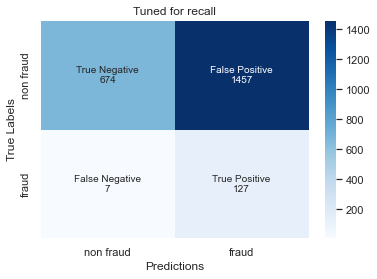

In [11]:
get_confusion_matrix(y_valid,y_pred, "Tuned for recall")

In [12]:
#creating an objective function
def objective(trial):

    #hyperparameters to tune
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    #creating the model
    lgb = LGBMClassifier(seed = 20, **param)
    lgb.fit(X_train_resampled, y_train_resampled)

    #classifying validation data
    y_pred = lgb.predict(X_valid)

    #measuring the evaluation metrics for the model
    recall = metrics.recall_score(y_valid, y_pred)
    fbeta = metrics.fbeta_score(y_valid, y_pred, beta = 2)
    return fbeta

In [13]:
#running 100 trials to find the hyperparameters that give the highest evaluation metric scores
study2 = optuna.create_study(direction="maximize")
study2.optimize(lambda trial : objective(trial) ,n_trials=100)
print("Number of finished trials: ", len(study2.trials))

[I 2022-11-17 23:22:45,583] A new study created in memory with name: no-name-34c03e07-db90-472d-b6ef-a2c5898856e0


[LightGBM] [Warning] feature_fraction is set=0.44284893328986497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44284893328986497
[LightGBM] [Warning] lambda_l1 is set=0.001812814426600764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001812814426600764
[LightGBM] [Warning] bagging_fraction is set=0.9083761627042726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9083761627042726
[LightGBM] [Warning] lambda_l2 is set=5.0875001935354695e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0875001935354695e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-17 23:22:46,945] Trial 0 finished with value: 0.19718309859154928 and parameters: {'lambda_l1': 0.001812814426600764, 'lambda_l2': 5.0875001935354695e-08, 'num_leaves': 184, 'feature_fraction': 0.44284893328986497, 'bagging_fraction': 0.9083761627042726, 'bagging_freq': 3, 'min_child_samples': 97}. Best is trial 0 with value: 0.19718309859154928.


[LightGBM] [Warning] feature_fraction is set=0.9449166171890977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9449166171890977
[LightGBM] [Warning] lambda_l1 is set=6.268395969065123e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.268395969065123e-08
[LightGBM] [Warning] bagging_fraction is set=0.4741222691317427, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4741222691317427
[LightGBM] [Warning] lambda_l2 is set=0.00017723947767424352, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017723947767424352
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-17 23:22:48,788] Trial 1 finished with value: 0.2983293556085919 and parameters: {'lambda_l1': 6.268395969065123e-08, 'lambda_l2': 0.00017723947767424352, 'num_leaves': 248, 'feature_fraction': 0.9449166171890977, 'bagging_fraction': 0.4741222691317427, 'bagging_freq': 1, 'min_child_samples': 29}. Best is trial 1 with value: 0.2983293556085919.


[LightGBM] [Warning] feature_fraction is set=0.47520720497410185, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47520720497410185
[LightGBM] [Warning] lambda_l1 is set=0.020396414647919452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.020396414647919452
[LightGBM] [Warning] bagging_fraction is set=0.9029876740752181, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9029876740752181
[LightGBM] [Warning] lambda_l2 is set=1.2859585529897818e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2859585529897818e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-17 23:22:50,367] Trial 2 finished with value: 0.19471488178025034 and parameters: {'lambda_l1': 0.020396414647919452, 'lambda_l2': 1.2859585529897818e-06, 'num_leaves': 118, 'feature_fraction': 0.47520720497410185, 'bagging_fraction': 0.9029876740752181, 'bagging_freq': 1, 'min_child_samples': 26}. Best is trial 1 with value: 0.2983293556085919.


[LightGBM] [Warning] feature_fraction is set=0.6770651953694542, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6770651953694542
[LightGBM] [Warning] lambda_l1 is set=5.118330139382717e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.118330139382717e-06
[LightGBM] [Warning] bagging_fraction is set=0.7497939202463481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7497939202463481
[LightGBM] [Warning] lambda_l2 is set=3.595734700878942, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.595734700878942
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-17 23:22:51,825] Trial 3 finished with value: 0.21711366538952745 and parameters: {'lambda_l1': 5.118330139382717e-06, 'lambda_l2': 3.595734700878942, 'num_leaves': 115, 'feature_fraction': 0.6770651953694542, 'bagging_fraction': 0.7497939202463481, 'bagging_freq': 6, 'min_child_samples': 64}. Best is trial 1 with value: 0.2983293556085919.


[LightGBM] [Warning] feature_fraction is set=0.7059928646029312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7059928646029312
[LightGBM] [Warning] lambda_l1 is set=3.0731951065573874e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0731951065573874e-06
[LightGBM] [Warning] bagging_fraction is set=0.7348324644612722, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7348324644612722
[LightGBM] [Warning] lambda_l2 is set=0.0019603493424757952, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019603493424757952
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-11-17 23:22:52,728] Trial 4 finished with value: 0.21540469973890342 and parameters: {'lambda_l1': 3.0731951065573874e-06, 'lambda_l2': 0.0019603493424757952, 'num_leaves': 40, 'feature_fraction': 0.7059928646029312, 'bagging_fraction': 0.7348324644612722, 'bagging_freq': 2, 'min_child_samples': 34}. Best is trial 1 with value: 0.2983293556085919.


[LightGBM] [Warning] feature_fraction is set=0.4986701316738165, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4986701316738165
[LightGBM] [Warning] lambda_l1 is set=0.020718609678835334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.020718609678835334
[LightGBM] [Warning] bagging_fraction is set=0.5428517956284745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5428517956284745
[LightGBM] [Warning] lambda_l2 is set=1.858038993388419e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.858038993388419e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:22:53,471] Trial 5 finished with value: 0.2308707124010554 and parameters: {'lambda_l1': 0.020718609678835334, 'lambda_l2': 1.858038993388419e-07, 'num_leaves': 226, 'feature_fraction': 0.4986701316738165, 'bagging_fraction': 0.5428517956284745, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial 1 with value: 0.2983293556085919.


[LightGBM] [Warning] feature_fraction is set=0.5765080754162651, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5765080754162651
[LightGBM] [Warning] lambda_l1 is set=0.08947173560972169, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08947173560972169
[LightGBM] [Warning] bagging_fraction is set=0.9392025718332588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9392025718332588
[LightGBM] [Warning] lambda_l2 is set=0.7729852126013272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7729852126013272
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-11-17 23:22:55,197] Trial 6 finished with value: 0.20223152022315202 and parameters: {'lambda_l1': 0.08947173560972169, 'lambda_l2': 0.7729852126013272, 'num_leaves': 187, 'feature_fraction': 0.5765080754162651, 'bagging_fraction': 0.9392025718332588, 'bagging_freq': 2, 'min_child_samples': 29}. Best is trial 1 with value: 0.2983293556085919.


[LightGBM] [Warning] feature_fraction is set=0.9445594257160828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9445594257160828
[LightGBM] [Warning] lambda_l1 is set=2.508960247709951e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.508960247709951e-08
[LightGBM] [Warning] bagging_fraction is set=0.8712581618509609, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8712581618509609
[LightGBM] [Warning] lambda_l2 is set=1.200953292199726e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.200953292199726e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-17 23:22:57,543] Trial 7 finished with value: 0.3321678321678322 and parameters: {'lambda_l1': 2.508960247709951e-08, 'lambda_l2': 1.200953292199726e-07, 'num_leaves': 142, 'feature_fraction': 0.9445594257160828, 'bagging_fraction': 0.8712581618509609, 'bagging_freq': 1, 'min_child_samples': 54}. Best is trial 7 with value: 0.3321678321678322.


[LightGBM] [Warning] feature_fraction is set=0.8319234621081305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8319234621081305
[LightGBM] [Warning] lambda_l1 is set=0.22745717867369286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22745717867369286
[LightGBM] [Warning] bagging_fraction is set=0.838850024769802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.838850024769802
[LightGBM] [Warning] lambda_l2 is set=1.0764064214030926e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0764064214030926e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:22:59,327] Trial 8 finished with value: 0.2581863979848867 and parameters: {'lambda_l1': 0.22745717867369286, 'lambda_l2': 1.0764064214030926e-08, 'num_leaves': 176, 'feature_fraction': 0.8319234621081305, 'bagging_fraction': 0.838850024769802, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 7 with value: 0.3321678321678322.


[LightGBM] [Warning] feature_fraction is set=0.7298627184919679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7298627184919679
[LightGBM] [Warning] lambda_l1 is set=4.5986658750725684e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5986658750725684e-05
[LightGBM] [Warning] bagging_fraction is set=0.5955873813471151, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5955873813471151
[LightGBM] [Warning] lambda_l2 is set=0.31732024577728973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.31732024577728973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-17 23:23:00,121] Trial 9 finished with value: 0.22965879265091863 and parameters: {'lambda_l1': 4.5986658750725684e-05, 'lambda_l2': 0.31732024577728973, 'num_leaves': 87, 'feature_fraction': 0.7298627184919679, 'bagging_fraction': 0.5955873813471151, 'bagging_freq': 1, 'min_child_samples': 76}. Best is trial 7 with value: 0.3321678321678322.


[LightGBM] [Warning] feature_fraction is set=0.9353732170264877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9353732170264877
[LightGBM] [Warning] lambda_l1 is set=6.198353041195703, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.198353041195703
[LightGBM] [Warning] bagging_fraction is set=0.9881898492457422, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9881898492457422
[LightGBM] [Warning] lambda_l2 is set=9.021976916835664e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.021976916835664e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:23:00,548] Trial 10 finished with value: 0.3297997644287397 and parameters: {'lambda_l1': 6.198353041195703, 'lambda_l2': 9.021976916835664e-06, 'num_leaves': 9, 'feature_fraction': 0.9353732170264877, 'bagging_fraction': 0.9881898492457422, 'bagging_freq': 4, 'min_child_samples': 52}. Best is trial 7 with value: 0.3321678321678322.


[LightGBM] [Warning] feature_fraction is set=0.9965141331336687, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9965141331336687
[LightGBM] [Warning] lambda_l1 is set=6.150958018273057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.150958018273057
[LightGBM] [Warning] bagging_fraction is set=0.9856372957031875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9856372957031875
[LightGBM] [Warning] lambda_l2 is set=7.282228405280319e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.282228405280319e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:23:01,187] Trial 11 finished with value: 0.3825431034482758 and parameters: {'lambda_l1': 6.150958018273057, 'lambda_l2': 7.282228405280319e-06, 'num_leaves': 22, 'feature_fraction': 0.9965141331336687, 'bagging_fraction': 0.9856372957031875, 'bagging_freq': 4, 'min_child_samples': 52}. Best is trial 11 with value: 0.3825431034482758.


[LightGBM] [Warning] feature_fraction is set=0.9938878078825523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9938878078825523
[LightGBM] [Warning] lambda_l1 is set=3.200246960882242e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.200246960882242e-08
[LightGBM] [Warning] bagging_fraction is set=0.780254337510107, subsample=1.0 will be ignored. Current value: bagging_fraction=0.780254337510107
[LightGBM] [Warning] lambda_l2 is set=1.610555346300782e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.610555346300782e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:23:02,781] Trial 12 finished with value: 0.34445640473627553 and parameters: {'lambda_l1': 3.200246960882242e-08, 'lambda_l2': 1.610555346300782e-05, 'num_leaves': 66, 'feature_fraction': 0.9938878078825523, 'bagging_fraction': 0.780254337510107, 'bagging_freq': 4, 'min_child_samples': 53}. Best is trial 11 with value: 0.3825431034482758.


[LightGBM] [Warning] feature_fraction is set=0.8174587317818501, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8174587317818501
[LightGBM] [Warning] lambda_l1 is set=3.0960279826465626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0960279826465626
[LightGBM] [Warning] bagging_fraction is set=0.6567660504919809, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6567660504919809
[LightGBM] [Warning] lambda_l2 is set=7.973823057525824e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.973823057525824e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:23:03,682] Trial 13 finished with value: 0.300578034682081 and parameters: {'lambda_l1': 3.0960279826465626, 'lambda_l2': 7.973823057525824e-05, 'num_leaves': 54, 'feature_fraction': 0.8174587317818501, 'bagging_fraction': 0.6567660504919809, 'bagging_freq': 4, 'min_child_samples': 50}. Best is trial 11 with value: 0.3825431034482758.
[I 2022-11-17 23:23:03,933] Trial 14 finished with value: 0.29714553111839026 and parameters: {'lambda_l1': 0.0003312051479952608, 'lambda_l2': 0.002408259998399214, 'num_leaves': 2, 'feature_fraction': 0.9919586724544804, 'bagging_fraction': 0.7945802211889474, 'bagging_freq': 5, 'min_child_samples': 74}. Best is trial 11 with value: 0.3825431034482758.


[LightGBM] [Warning] feature_fraction is set=0.9919586724544804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9919586724544804
[LightGBM] [Warning] lambda_l1 is set=0.0003312051479952608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003312051479952608
[LightGBM] [Warning] bagging_fraction is set=0.7945802211889474, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7945802211889474
[LightGBM] [Warning] lambda_l2 is set=0.002408259998399214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002408259998399214
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8582432640146339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8582432640146339
[LightGBM] [Warning] lambda_l1 is set=2.790990746192625e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.790990746192625e-06
[LightGBM] [Warning] 

[I 2022-11-17 23:23:04,855] Trial 15 finished with value: 0.3001200480192077 and parameters: {'lambda_l1': 2.790990746192625e-06, 'lambda_l2': 5.894308810500384e-06, 'num_leaves': 63, 'feature_fraction': 0.8582432640146339, 'bagging_fraction': 0.4075429105574154, 'bagging_freq': 3, 'min_child_samples': 43}. Best is trial 11 with value: 0.3825431034482758.


[LightGBM] [Warning] feature_fraction is set=0.8813220164228623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8813220164228623
[LightGBM] [Warning] lambda_l1 is set=1.5157380335840733e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5157380335840733e-07
[LightGBM] [Warning] bagging_fraction is set=0.9930911544945004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9930911544945004
[LightGBM] [Warning] lambda_l2 is set=0.012630152921561283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012630152921561283
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:23:05,661] Trial 16 finished with value: 0.23929471032745592 and parameters: {'lambda_l1': 1.5157380335840733e-07, 'lambda_l2': 0.012630152921561283, 'num_leaves': 33, 'feature_fraction': 0.8813220164228623, 'bagging_fraction': 0.9930911544945004, 'bagging_freq': 5, 'min_child_samples': 64}. Best is trial 11 with value: 0.3825431034482758.


[LightGBM] [Warning] feature_fraction is set=0.7756319208068041, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7756319208068041
[LightGBM] [Warning] lambda_l1 is set=0.0017232171369689002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017232171369689002
[LightGBM] [Warning] bagging_fraction is set=0.8016929013044135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8016929013044135
[LightGBM] [Warning] lambda_l2 is set=1.2678203596063453e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2678203596063453e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-17 23:23:06,958] Trial 17 finished with value: 0.21767810026385223 and parameters: {'lambda_l1': 0.0017232171369689002, 'lambda_l2': 1.2678203596063453e-05, 'num_leaves': 70, 'feature_fraction': 0.7756319208068041, 'bagging_fraction': 0.8016929013044135, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 11 with value: 0.3825431034482758.


[LightGBM] [Warning] feature_fraction is set=0.9951131385360856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9951131385360856
[LightGBM] [Warning] lambda_l1 is set=2.8878314438070918e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8878314438070918e-05
[LightGBM] [Warning] bagging_fraction is set=0.664614296523728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.664614296523728
[LightGBM] [Warning] lambda_l2 is set=9.414385708240957e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.414385708240957e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:23:08,575] Trial 18 finished with value: 0.319634703196347 and parameters: {'lambda_l1': 2.8878314438070918e-05, 'lambda_l2': 9.414385708240957e-07, 'num_leaves': 92, 'feature_fraction': 0.9951131385360856, 'bagging_fraction': 0.664614296523728, 'bagging_freq': 4, 'min_child_samples': 85}. Best is trial 11 with value: 0.3825431034482758.


[LightGBM] [Warning] feature_fraction is set=0.6332217410341123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6332217410341123
[LightGBM] [Warning] lambda_l1 is set=5.877644659461366e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.877644659461366e-07
[LightGBM] [Warning] bagging_fraction is set=0.5830655779223843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5830655779223843
[LightGBM] [Warning] lambda_l2 is set=4.944017915054992e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.944017915054992e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-17 23:23:09,573] Trial 19 finished with value: 0.23017902813299232 and parameters: {'lambda_l1': 5.877644659461366e-07, 'lambda_l2': 4.944017915054992e-05, 'num_leaves': 40, 'feature_fraction': 0.6332217410341123, 'bagging_fraction': 0.5830655779223843, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 11 with value: 0.3825431034482758.


[LightGBM] [Warning] feature_fraction is set=0.8982229632326308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8982229632326308
[LightGBM] [Warning] lambda_l1 is set=1.2827932716895322e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2827932716895322e-08
[LightGBM] [Warning] bagging_fraction is set=0.7047231447363377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7047231447363377
[LightGBM] [Warning] lambda_l2 is set=0.0009217411647152887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009217411647152887
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-17 23:23:10,835] Trial 20 finished with value: 0.2787878787878788 and parameters: {'lambda_l1': 1.2827932716895322e-08, 'lambda_l2': 0.0009217411647152887, 'num_leaves': 93, 'feature_fraction': 0.8982229632326308, 'bagging_fraction': 0.7047231447363377, 'bagging_freq': 6, 'min_child_samples': 63}. Best is trial 11 with value: 0.3825431034482758.


[LightGBM] [Warning] feature_fraction is set=0.9359683059615482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9359683059615482
[LightGBM] [Warning] lambda_l1 is set=1.2333481234233993e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2333481234233993e-08
[LightGBM] [Warning] bagging_fraction is set=0.8559216421676569, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8559216421676569
[LightGBM] [Warning] lambda_l2 is set=4.0973618398427805e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0973618398427805e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-11-17 23:23:12,704] Trial 21 finished with value: 0.2726218097447796 and parameters: {'lambda_l1': 1.2333481234233993e-08, 'lambda_l2': 4.0973618398427805e-07, 'num_leaves': 145, 'feature_fraction': 0.9359683059615482, 'bagging_fraction': 0.8559216421676569, 'bagging_freq': 2, 'min_child_samples': 57}. Best is trial 11 with value: 0.3825431034482758.


[LightGBM] [Warning] feature_fraction is set=0.999479696354388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999479696354388
[LightGBM] [Warning] lambda_l1 is set=1.2579529869334485e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2579529869334485e-07
[LightGBM] [Warning] bagging_fraction is set=0.8724106684007988, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8724106684007988
[LightGBM] [Warning] lambda_l2 is set=7.840322058677527e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.840322058677527e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-17 23:23:14,866] Trial 22 finished with value: 0.3385127635960044 and parameters: {'lambda_l1': 1.2579529869334485e-07, 'lambda_l2': 7.840322058677527e-08, 'num_leaves': 152, 'feature_fraction': 0.999479696354388, 'bagging_fraction': 0.8724106684007988, 'bagging_freq': 3, 'min_child_samples': 45}. Best is trial 11 with value: 0.3825431034482758.


[LightGBM] [Warning] feature_fraction is set=0.998402286020024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.998402286020024
[LightGBM] [Warning] lambda_l1 is set=4.827597848096822e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.827597848096822e-07
[LightGBM] [Warning] bagging_fraction is set=0.9567072201001572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9567072201001572
[LightGBM] [Warning] lambda_l2 is set=1.0107646703906576e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0107646703906576e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-17 23:23:16,844] Trial 23 finished with value: 0.33183352080989875 and parameters: {'lambda_l1': 4.827597848096822e-07, 'lambda_l2': 1.0107646703906576e-08, 'num_leaves': 154, 'feature_fraction': 0.998402286020024, 'bagging_fraction': 0.9567072201001572, 'bagging_freq': 3, 'min_child_samples': 44}. Best is trial 11 with value: 0.3825431034482758.


[LightGBM] [Warning] feature_fraction is set=0.7799341987001913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7799341987001913
[LightGBM] [Warning] lambda_l1 is set=2.775456012687638e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.775456012687638e-07
[LightGBM] [Warning] bagging_fraction is set=0.7997132996815487, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7997132996815487
[LightGBM] [Warning] lambda_l2 is set=1.8770419730721902e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8770419730721902e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:23:17,325] Trial 24 finished with value: 0.24 and parameters: {'lambda_l1': 2.775456012687638e-07, 'lambda_l2': 1.8770419730721902e-06, 'num_leaves': 12, 'feature_fraction': 0.7799341987001913, 'bagging_fraction': 0.7997132996815487, 'bagging_freq': 4, 'min_child_samples': 71}. Best is trial 11 with value: 0.3825431034482758.


[LightGBM] [Warning] feature_fraction is set=0.8971593250092694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8971593250092694
[LightGBM] [Warning] lambda_l1 is set=0.9942505272221595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9942505272221595
[LightGBM] [Warning] bagging_fraction is set=0.9227572840569948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9227572840569948
[LightGBM] [Warning] lambda_l2 is set=2.5354817003763452e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5354817003763452e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:23:17,967] Trial 25 finished with value: 0.30035335689045933 and parameters: {'lambda_l1': 0.9942505272221595, 'lambda_l2': 2.5354817003763452e-05, 'num_leaves': 24, 'feature_fraction': 0.8971593250092694, 'bagging_fraction': 0.9227572840569948, 'bagging_freq': 5, 'min_child_samples': 37}. Best is trial 11 with value: 0.3825431034482758.


[LightGBM] [Warning] feature_fraction is set=0.9581125486557825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9581125486557825
[LightGBM] [Warning] lambda_l1 is set=3.4903000645336474e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4903000645336474e-05
[LightGBM] [Warning] bagging_fraction is set=0.8715250652017336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8715250652017336
[LightGBM] [Warning] lambda_l2 is set=0.01889855553004632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01889855553004632
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-17 23:23:21,025] Trial 26 finished with value: 0.3185096153846154 and parameters: {'lambda_l1': 3.4903000645336474e-05, 'lambda_l2': 0.01889855553004632, 'num_leaves': 214, 'feature_fraction': 0.9581125486557825, 'bagging_fraction': 0.8715250652017336, 'bagging_freq': 3, 'min_child_samples': 17}. Best is trial 11 with value: 0.3825431034482758.


[LightGBM] [Warning] feature_fraction is set=0.9180529289081102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9180529289081102
[LightGBM] [Warning] lambda_l1 is set=0.00042042597214171277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00042042597214171277
[LightGBM] [Warning] bagging_fraction is set=0.7509203174836089, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7509203174836089
[LightGBM] [Warning] lambda_l2 is set=3.647902064666646e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.647902064666646e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:23:22,902] Trial 27 finished with value: 0.25402726146220567 and parameters: {'lambda_l1': 0.00042042597214171277, 'lambda_l2': 3.647902064666646e-06, 'num_leaves': 115, 'feature_fraction': 0.9180529289081102, 'bagging_fraction': 0.7509203174836089, 'bagging_freq': 4, 'min_child_samples': 46}. Best is trial 11 with value: 0.3825431034482758.


[LightGBM] [Warning] feature_fraction is set=0.8592433370085499, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8592433370085499
[LightGBM] [Warning] lambda_l1 is set=1.0499092359466427e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0499092359466427e-07
[LightGBM] [Warning] bagging_fraction is set=0.8190958579456425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8190958579456425
[LightGBM] [Warning] lambda_l2 is set=4.3844150040836504e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3844150040836504e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-11-17 23:23:24,741] Trial 28 finished with value: 0.24234693877551017 and parameters: {'lambda_l1': 1.0499092359466427e-07, 'lambda_l2': 4.3844150040836504e-08, 'num_leaves': 164, 'feature_fraction': 0.8592433370085499, 'bagging_fraction': 0.8190958579456425, 'bagging_freq': 2, 'min_child_samples': 57}. Best is trial 11 with value: 0.3825431034482758.


[LightGBM] [Warning] feature_fraction is set=0.41373193535430713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41373193535430713
[LightGBM] [Warning] lambda_l1 is set=1.2421409172701531e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2421409172701531e-06
[LightGBM] [Warning] bagging_fraction is set=0.9081994523224369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9081994523224369
[LightGBM] [Warning] lambda_l2 is set=4.773822560521463e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.773822560521463e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-17 23:23:26,348] Trial 29 finished with value: 0.1744186046511628 and parameters: {'lambda_l1': 1.2421409172701531e-06, 'lambda_l2': 4.773822560521463e-08, 'num_leaves': 72, 'feature_fraction': 0.41373193535430713, 'bagging_fraction': 0.9081994523224369, 'bagging_freq': 3, 'min_child_samples': 91}. Best is trial 11 with value: 0.3825431034482758.


[LightGBM] [Warning] feature_fraction is set=0.9740810846101365, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9740810846101365
[LightGBM] [Warning] lambda_l1 is set=0.0023773809609792455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0023773809609792455
[LightGBM] [Warning] bagging_fraction is set=0.9670999311866968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9670999311866968
[LightGBM] [Warning] lambda_l2 is set=0.0004391893404674366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004391893404674366
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:23:27,406] Trial 30 finished with value: 0.34002229654403565 and parameters: {'lambda_l1': 0.0023773809609792455, 'lambda_l2': 0.0004391893404674366, 'num_leaves': 47, 'feature_fraction': 0.9740810846101365, 'bagging_fraction': 0.9670999311866968, 'bagging_freq': 5, 'min_child_samples': 83}. Best is trial 11 with value: 0.3825431034482758.


[LightGBM] [Warning] feature_fraction is set=0.9871730746280367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9871730746280367
[LightGBM] [Warning] lambda_l1 is set=0.00434131325619773, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00434131325619773
[LightGBM] [Warning] bagging_fraction is set=0.9703866625993979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9703866625993979
[LightGBM] [Warning] lambda_l2 is set=0.0007427858946723063, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007427858946723063
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:23:28,392] Trial 31 finished with value: 0.31213872832369943 and parameters: {'lambda_l1': 0.00434131325619773, 'lambda_l2': 0.0007427858946723063, 'num_leaves': 51, 'feature_fraction': 0.9871730746280367, 'bagging_fraction': 0.9703866625993979, 'bagging_freq': 5, 'min_child_samples': 82}. Best is trial 11 with value: 0.3825431034482758.


[LightGBM] [Warning] feature_fraction is set=0.9639569438636112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9639569438636112
[LightGBM] [Warning] lambda_l1 is set=0.6042169602351947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6042169602351947
[LightGBM] [Warning] bagging_fraction is set=0.8867640556952651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8867640556952651
[LightGBM] [Warning] lambda_l2 is set=0.00019877480539380824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019877480539380824
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:23:29,102] Trial 32 finished with value: 0.3705752212389381 and parameters: {'lambda_l1': 0.6042169602351947, 'lambda_l2': 0.00019877480539380824, 'num_leaves': 22, 'feature_fraction': 0.9639569438636112, 'bagging_fraction': 0.8867640556952651, 'bagging_freq': 4, 'min_child_samples': 21}. Best is trial 11 with value: 0.3825431034482758.


[LightGBM] [Warning] feature_fraction is set=0.9568213229830116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9568213229830116
[LightGBM] [Warning] lambda_l1 is set=0.2625562784889671, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2625562784889671
[LightGBM] [Warning] bagging_fraction is set=0.9347699765351698, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9347699765351698
[LightGBM] [Warning] lambda_l2 is set=0.00018172462413588013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018172462413588013
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:23:29,867] Trial 33 finished with value: 0.38335158817086523 and parameters: {'lambda_l1': 0.2625562784889671, 'lambda_l2': 0.00018172462413588013, 'num_leaves': 25, 'feature_fraction': 0.9568213229830116, 'bagging_fraction': 0.9347699765351698, 'bagging_freq': 4, 'min_child_samples': 22}. Best is trial 33 with value: 0.38335158817086523.


[LightGBM] [Warning] feature_fraction is set=0.9185415425343922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9185415425343922
[LightGBM] [Warning] lambda_l1 is set=0.8792528612607404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8792528612607404
[LightGBM] [Warning] bagging_fraction is set=0.9107991025656819, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9107991025656819
[LightGBM] [Warning] lambda_l2 is set=0.00015559211843151245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015559211843151245
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:23:30,605] Trial 34 finished with value: 0.34116331096196867 and parameters: {'lambda_l1': 0.8792528612607404, 'lambda_l2': 0.00015559211843151245, 'num_leaves': 27, 'feature_fraction': 0.9185415425343922, 'bagging_fraction': 0.9107991025656819, 'bagging_freq': 4, 'min_child_samples': 20}. Best is trial 33 with value: 0.38335158817086523.


[LightGBM] [Warning] feature_fraction is set=0.9620083872449925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9620083872449925
[LightGBM] [Warning] lambda_l1 is set=0.13161795150507458, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13161795150507458
[LightGBM] [Warning] bagging_fraction is set=0.8963076160382457, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8963076160382457
[LightGBM] [Warning] lambda_l2 is set=3.383310831026962e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.383310831026962e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:23:31,741] Trial 35 finished with value: 0.3837837837837838 and parameters: {'lambda_l1': 0.13161795150507458, 'lambda_l2': 3.383310831026962e-05, 'num_leaves': 18, 'feature_fraction': 0.9620083872449925, 'bagging_fraction': 0.8963076160382457, 'bagging_freq': 4, 'min_child_samples': 24}. Best is trial 35 with value: 0.3837837837837838.


[LightGBM] [Warning] feature_fraction is set=0.870511299047951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.870511299047951
[LightGBM] [Warning] lambda_l1 is set=0.10298992926011287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10298992926011287
[LightGBM] [Warning] bagging_fraction is set=0.9317829914384838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9317829914384838
[LightGBM] [Warning] lambda_l2 is set=0.00014085209556854896, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014085209556854896
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:23:32,514] Trial 36 finished with value: 0.3106682297772567 and parameters: {'lambda_l1': 0.10298992926011287, 'lambda_l2': 0.00014085209556854896, 'num_leaves': 19, 'feature_fraction': 0.870511299047951, 'bagging_fraction': 0.9317829914384838, 'bagging_freq': 4, 'min_child_samples': 25}. Best is trial 35 with value: 0.3837837837837838.


[LightGBM] [Warning] feature_fraction is set=0.8224521236541084, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8224521236541084
[LightGBM] [Warning] lambda_l1 is set=9.904051435784114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.904051435784114
[LightGBM] [Warning] bagging_fraction is set=0.8911511877770694, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8911511877770694
[LightGBM] [Warning] lambda_l2 is set=0.008885475382157447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008885475382157447
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:23:32,887] Trial 37 finished with value: 0.2567829457364341 and parameters: {'lambda_l1': 9.904051435784114, 'lambda_l2': 0.008885475382157447, 'num_leaves': 4, 'feature_fraction': 0.8224521236541084, 'bagging_fraction': 0.8911511877770694, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 35 with value: 0.3837837837837838.


[LightGBM] [Warning] feature_fraction is set=0.5867955118495667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5867955118495667
[LightGBM] [Warning] lambda_l1 is set=0.5657404750516288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5657404750516288
[LightGBM] [Warning] bagging_fraction is set=0.9483348672724029, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9483348672724029
[LightGBM] [Warning] lambda_l2 is set=3.7138077702110163e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7138077702110163e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-17 23:23:33,786] Trial 38 finished with value: 0.20027624309392264 and parameters: {'lambda_l1': 0.5657404750516288, 'lambda_l2': 3.7138077702110163e-05, 'num_leaves': 32, 'feature_fraction': 0.5867955118495667, 'bagging_fraction': 0.9483348672724029, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 35 with value: 0.3837837837837838.


[LightGBM] [Warning] feature_fraction is set=0.9410580492332815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9410580492332815
[LightGBM] [Warning] lambda_l1 is set=0.02806527693839283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02806527693839283
[LightGBM] [Warning] bagging_fraction is set=0.8413134894545442, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8413134894545442
[LightGBM] [Warning] lambda_l2 is set=0.004389306639364783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004389306639364783
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-17 23:23:34,427] Trial 39 finished with value: 0.3496115427302997 and parameters: {'lambda_l1': 0.02806527693839283, 'lambda_l2': 0.004389306639364783, 'num_leaves': 21, 'feature_fraction': 0.9410580492332815, 'bagging_fraction': 0.8413134894545442, 'bagging_freq': 7, 'min_child_samples': 25}. Best is trial 35 with value: 0.3837837837837838.


[LightGBM] [Warning] feature_fraction is set=0.9572539311118234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9572539311118234
[LightGBM] [Warning] lambda_l1 is set=3.0840766188826114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0840766188826114
[LightGBM] [Warning] bagging_fraction is set=0.9970712163782729, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9970712163782729
[LightGBM] [Warning] lambda_l2 is set=0.00021725066582835588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00021725066582835588
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:23:36,322] Trial 40 finished with value: 0.3808487486398259 and parameters: {'lambda_l1': 3.0840766188826114, 'lambda_l2': 0.00021725066582835588, 'num_leaves': 85, 'feature_fraction': 0.9572539311118234, 'bagging_fraction': 0.9970712163782729, 'bagging_freq': 4, 'min_child_samples': 13}. Best is trial 35 with value: 0.3837837837837838.


[LightGBM] [Warning] feature_fraction is set=0.9632921637012325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9632921637012325
[LightGBM] [Warning] lambda_l1 is set=2.2761133601177477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2761133601177477
[LightGBM] [Warning] bagging_fraction is set=0.9983839596670088, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9983839596670088
[LightGBM] [Warning] lambda_l2 is set=0.00028643728340510245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00028643728340510245
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:23:38,824] Trial 41 finished with value: 0.3638368246968027 and parameters: {'lambda_l1': 2.2761133601177477, 'lambda_l2': 0.00028643728340510245, 'num_leaves': 128, 'feature_fraction': 0.9632921637012325, 'bagging_fraction': 0.9983839596670088, 'bagging_freq': 4, 'min_child_samples': 15}. Best is trial 35 with value: 0.3837837837837838.


[LightGBM] [Warning] feature_fraction is set=0.9039308180660772, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9039308180660772
[LightGBM] [Warning] lambda_l1 is set=0.33939366558795464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33939366558795464
[LightGBM] [Warning] bagging_fraction is set=0.9374827384769344, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9374827384769344
[LightGBM] [Warning] lambda_l2 is set=0.05657939100741195, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05657939100741195
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:23:41,637] Trial 42 finished with value: 0.29411764705882354 and parameters: {'lambda_l1': 0.33939366558795464, 'lambda_l2': 0.05657939100741195, 'num_leaves': 37, 'feature_fraction': 0.9039308180660772, 'bagging_fraction': 0.9374827384769344, 'bagging_freq': 4, 'min_child_samples': 21}. Best is trial 35 with value: 0.3837837837837838.


[LightGBM] [Warning] feature_fraction is set=0.9554408013475422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9554408013475422
[LightGBM] [Warning] lambda_l1 is set=0.059806499496435656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.059806499496435656
[LightGBM] [Warning] bagging_fraction is set=0.9672115235501602, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9672115235501602
[LightGBM] [Warning] lambda_l2 is set=9.159080581803312e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.159080581803312e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:23:44,570] Trial 43 finished with value: 0.3275862068965517 and parameters: {'lambda_l1': 0.059806499496435656, 'lambda_l2': 9.159080581803312e-05, 'num_leaves': 77, 'feature_fraction': 0.9554408013475422, 'bagging_fraction': 0.9672115235501602, 'bagging_freq': 4, 'min_child_samples': 33}. Best is trial 35 with value: 0.3837837837837838.


[LightGBM] [Warning] feature_fraction is set=0.9248529086859776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9248529086859776
[LightGBM] [Warning] lambda_l1 is set=1.9575985737592385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9575985737592385
[LightGBM] [Warning] bagging_fraction is set=0.8941362707272333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8941362707272333
[LightGBM] [Warning] lambda_l2 is set=0.0018324315574509966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0018324315574509966
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-17 23:23:46,082] Trial 44 finished with value: 0.36423841059602646 and parameters: {'lambda_l1': 1.9575985737592385, 'lambda_l2': 0.0018324315574509966, 'num_leaves': 105, 'feature_fraction': 0.9248529086859776, 'bagging_fraction': 0.8941362707272333, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 35 with value: 0.3837837837837838.


[LightGBM] [Warning] feature_fraction is set=0.5054495350285875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5054495350285875
[LightGBM] [Warning] lambda_l1 is set=0.20793925618490403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20793925618490403
[LightGBM] [Warning] bagging_fraction is set=0.9773645789659935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9773645789659935
[LightGBM] [Warning] lambda_l2 is set=2.1049926967324306e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1049926967324306e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:23:47,753] Trial 45 finished with value: 0.2017291066282421 and parameters: {'lambda_l1': 0.20793925618490403, 'lambda_l2': 2.1049926967324306e-06, 'num_leaves': 53, 'feature_fraction': 0.5054495350285875, 'bagging_fraction': 0.9773645789659935, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 35 with value: 0.3837837837837838.


[LightGBM] [Warning] feature_fraction is set=0.9602352057631319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9602352057631319
[LightGBM] [Warning] lambda_l1 is set=4.414134162126744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.414134162126744
[LightGBM] [Warning] bagging_fraction is set=0.9992599471755395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9992599471755395
[LightGBM] [Warning] lambda_l2 is set=0.0002482867252443379, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002482867252443379
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-17 23:23:48,978] Trial 46 finished with value: 0.2886977886977887 and parameters: {'lambda_l1': 4.414134162126744, 'lambda_l2': 0.0002482867252443379, 'num_leaves': 15, 'feature_fraction': 0.9602352057631319, 'bagging_fraction': 0.9992599471755395, 'bagging_freq': 3, 'min_child_samples': 27}. Best is trial 35 with value: 0.3837837837837838.


[LightGBM] [Warning] feature_fraction is set=0.7987777942236088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7987777942236088
[LightGBM] [Warning] lambda_l1 is set=0.008583309750958395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008583309750958395
[LightGBM] [Warning] bagging_fraction is set=0.9360770106704787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9360770106704787
[LightGBM] [Warning] lambda_l2 is set=2.612231039812374e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.612231039812374e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:23:51,166] Trial 47 finished with value: 0.3220140515222482 and parameters: {'lambda_l1': 0.008583309750958395, 'lambda_l2': 2.612231039812374e-05, 'num_leaves': 60, 'feature_fraction': 0.7987777942236088, 'bagging_fraction': 0.9360770106704787, 'bagging_freq': 4, 'min_child_samples': 21}. Best is trial 35 with value: 0.3837837837837838.


[LightGBM] [Warning] feature_fraction is set=0.7176840213002318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7176840213002318
[LightGBM] [Warning] lambda_l1 is set=1.5342746811463686, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5342746811463686
[LightGBM] [Warning] bagging_fraction is set=0.8962918508872328, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8962918508872328
[LightGBM] [Warning] lambda_l2 is set=7.299561093429005e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.299561093429005e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:23:53,170] Trial 48 finished with value: 0.23302263648468707 and parameters: {'lambda_l1': 1.5342746811463686, 'lambda_l2': 7.299561093429005e-06, 'num_leaves': 80, 'feature_fraction': 0.7176840213002318, 'bagging_fraction': 0.8962918508872328, 'bagging_freq': 4, 'min_child_samples': 36}. Best is trial 35 with value: 0.3837837837837838.


[LightGBM] [Warning] feature_fraction is set=0.8510551371906976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8510551371906976
[LightGBM] [Warning] lambda_l1 is set=0.17115663703110523, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17115663703110523
[LightGBM] [Warning] bagging_fraction is set=0.5055329213958396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5055329213958396
[LightGBM] [Warning] lambda_l2 is set=0.0004992161242931457, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004992161242931457
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:23:54,210] Trial 49 finished with value: 0.3493699885452463 and parameters: {'lambda_l1': 0.17115663703110523, 'lambda_l2': 0.0004992161242931457, 'num_leaves': 45, 'feature_fraction': 0.8510551371906976, 'bagging_fraction': 0.5055329213958396, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 35 with value: 0.3837837837837838.


[LightGBM] [Warning] feature_fraction is set=0.8897487483418209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8897487483418209
[LightGBM] [Warning] lambda_l1 is set=0.5106284266577926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5106284266577926
[LightGBM] [Warning] bagging_fraction is set=0.8382603228810837, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8382603228810837
[LightGBM] [Warning] lambda_l2 is set=6.540953726899004e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.540953726899004e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-11-17 23:23:56,707] Trial 50 finished with value: 0.2714113389626056 and parameters: {'lambda_l1': 0.5106284266577926, 'lambda_l2': 6.540953726899004e-05, 'num_leaves': 101, 'feature_fraction': 0.8897487483418209, 'bagging_fraction': 0.8382603228810837, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 35 with value: 0.3837837837837838.


[LightGBM] [Warning] feature_fraction is set=0.9242121862596575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9242121862596575
[LightGBM] [Warning] lambda_l1 is set=2.643319189118701, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.643319189118701
[LightGBM] [Warning] bagging_fraction is set=0.8999885667972922, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8999885667972922
[LightGBM] [Warning] lambda_l2 is set=0.0022492730035051597, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0022492730035051597
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-17 23:23:58,437] Trial 51 finished with value: 0.3446389496717724 and parameters: {'lambda_l1': 2.643319189118701, 'lambda_l2': 0.0022492730035051597, 'num_leaves': 119, 'feature_fraction': 0.9242121862596575, 'bagging_fraction': 0.8999885667972922, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 35 with value: 0.3837837837837838.


[LightGBM] [Warning] feature_fraction is set=0.9743134585197163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9743134585197163
[LightGBM] [Warning] lambda_l1 is set=9.462851397424053, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.462851397424053
[LightGBM] [Warning] bagging_fraction is set=0.8780725329413284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8780725329413284
[LightGBM] [Warning] lambda_l2 is set=0.001058267438782969, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001058267438782969
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:23:59,068] Trial 52 finished with value: 0.32863849765258213 and parameters: {'lambda_l1': 9.462851397424053, 'lambda_l2': 0.001058267438782969, 'num_leaves': 12, 'feature_fraction': 0.9743134585197163, 'bagging_fraction': 0.8780725329413284, 'bagging_freq': 4, 'min_child_samples': 6}. Best is trial 35 with value: 0.3837837837837838.


[LightGBM] [Warning] feature_fraction is set=0.9324378636819551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9324378636819551
[LightGBM] [Warning] lambda_l1 is set=1.512300289595286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.512300289595286
[LightGBM] [Warning] bagging_fraction is set=0.9207238863800591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9207238863800591
[LightGBM] [Warning] lambda_l2 is set=0.0750736160320158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0750736160320158
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-17 23:24:00,555] Trial 53 finished with value: 0.32909930715935337 and parameters: {'lambda_l1': 1.512300289595286, 'lambda_l2': 0.0750736160320158, 'num_leaves': 30, 'feature_fraction': 0.9324378636819551, 'bagging_fraction': 0.9207238863800591, 'bagging_freq': 3, 'min_child_samples': 23}. Best is trial 35 with value: 0.3837837837837838.


[LightGBM] [Warning] feature_fraction is set=0.6711357864711904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6711357864711904
[LightGBM] [Warning] lambda_l1 is set=0.03392535723147986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03392535723147986
[LightGBM] [Warning] bagging_fraction is set=0.9471923141666133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9471923141666133
[LightGBM] [Warning] lambda_l2 is set=5.979139274396417, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.979139274396417
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:02,797] Trial 54 finished with value: 0.24234693877551017 and parameters: {'lambda_l1': 0.03392535723147986, 'lambda_l2': 5.979139274396417, 'num_leaves': 103, 'feature_fraction': 0.6711357864711904, 'bagging_fraction': 0.9471923141666133, 'bagging_freq': 4, 'min_child_samples': 13}. Best is trial 35 with value: 0.3837837837837838.


[LightGBM] [Warning] feature_fraction is set=0.9722138153292093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9722138153292093
[LightGBM] [Warning] lambda_l1 is set=4.596716091906942, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.596716091906942
[LightGBM] [Warning] bagging_fraction is set=0.7673254465332504, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7673254465332504
[LightGBM] [Warning] lambda_l2 is set=0.0015937613618866365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015937613618866365
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-17 23:24:03,573] Trial 55 finished with value: 0.326485693323551 and parameters: {'lambda_l1': 4.596716091906942, 'lambda_l2': 0.0015937613618866365, 'num_leaves': 3, 'feature_fraction': 0.9722138153292093, 'bagging_fraction': 0.7673254465332504, 'bagging_freq': 3, 'min_child_samples': 17}. Best is trial 35 with value: 0.3837837837837838.


[LightGBM] [Warning] feature_fraction is set=0.9461989813366628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9461989813366628
[LightGBM] [Warning] lambda_l1 is set=0.08149290491959402, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08149290491959402
[LightGBM] [Warning] bagging_fraction is set=0.8515325250997013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8515325250997013
[LightGBM] [Warning] lambda_l2 is set=1.5481421244894465e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5481421244894465e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:24:06,301] Trial 56 finished with value: 0.329608938547486 and parameters: {'lambda_l1': 0.08149290491959402, 'lambda_l2': 1.5481421244894465e-05, 'num_leaves': 131, 'feature_fraction': 0.9461989813366628, 'bagging_fraction': 0.8515325250997013, 'bagging_freq': 5, 'min_child_samples': 27}. Best is trial 35 with value: 0.3837837837837838.


[LightGBM] [Warning] feature_fraction is set=0.8413385637830507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8413385637830507
[LightGBM] [Warning] lambda_l1 is set=0.5113997906161873, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5113997906161873
[LightGBM] [Warning] bagging_fraction is set=0.8224386220642199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8224386220642199
[LightGBM] [Warning] lambda_l2 is set=0.004550519656768045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004550519656768045
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2022-11-17 23:24:08,757] Trial 57 finished with value: 0.31464530892448517 and parameters: {'lambda_l1': 0.5113997906161873, 'lambda_l2': 0.004550519656768045, 'num_leaves': 62, 'feature_fraction': 0.8413385637830507, 'bagging_fraction': 0.8224386220642199, 'bagging_freq': 2, 'min_child_samples': 30}. Best is trial 35 with value: 0.3837837837837838.


[LightGBM] [Warning] feature_fraction is set=0.9078412799177783, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9078412799177783
[LightGBM] [Warning] lambda_l1 is set=1.0865770046203953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0865770046203953
[LightGBM] [Warning] bagging_fraction is set=0.9829135173602719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9829135173602719
[LightGBM] [Warning] lambda_l2 is set=0.00010861631373517902, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010861631373517902
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:10,686] Trial 58 finished with value: 0.2647783251231527 and parameters: {'lambda_l1': 1.0865770046203953, 'lambda_l2': 0.00010861631373517902, 'num_leaves': 105, 'feature_fraction': 0.9078412799177783, 'bagging_fraction': 0.9829135173602719, 'bagging_freq': 4, 'min_child_samples': 12}. Best is trial 35 with value: 0.3837837837837838.


[LightGBM] [Warning] feature_fraction is set=0.8787817356596274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8787817356596274
[LightGBM] [Warning] lambda_l1 is set=0.19536158696351882, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19536158696351882
[LightGBM] [Warning] bagging_fraction is set=0.9545837513294293, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9545837513294293
[LightGBM] [Warning] lambda_l2 is set=7.130094456724234e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.130094456724234e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-17 23:24:11,534] Trial 59 finished with value: 0.2374839537869063 and parameters: {'lambda_l1': 0.19536158696351882, 'lambda_l2': 7.130094456724234e-07, 'num_leaves': 39, 'feature_fraction': 0.8787817356596274, 'bagging_fraction': 0.9545837513294293, 'bagging_freq': 3, 'min_child_samples': 69}. Best is trial 35 with value: 0.3837837837837838.


[LightGBM] [Warning] feature_fraction is set=0.9738178262621324, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9738178262621324
[LightGBM] [Warning] lambda_l1 is set=6.254030785933313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.254030785933313
[LightGBM] [Warning] bagging_fraction is set=0.8770680950576624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8770680950576624
[LightGBM] [Warning] lambda_l2 is set=4.067221129983599e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.067221129983599e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:12,189] Trial 60 finished with value: 0.37685774946921446 and parameters: {'lambda_l1': 6.254030785933313, 'lambda_l2': 4.067221129983599e-06, 'num_leaves': 22, 'feature_fraction': 0.9738178262621324, 'bagging_fraction': 0.8770680950576624, 'bagging_freq': 4, 'min_child_samples': 23}. Best is trial 35 with value: 0.3837837837837838.


[LightGBM] [Warning] feature_fraction is set=0.9758727662661313, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9758727662661313
[LightGBM] [Warning] lambda_l1 is set=3.594083031206644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.594083031206644
[LightGBM] [Warning] bagging_fraction is set=0.8639504634625346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8639504634625346
[LightGBM] [Warning] lambda_l2 is set=4.96146620728708e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.96146620728708e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:13,536] Trial 61 finished with value: 0.39313399778516056 and parameters: {'lambda_l1': 3.594083031206644, 'lambda_l2': 4.96146620728708e-06, 'num_leaves': 19, 'feature_fraction': 0.9758727662661313, 'bagging_fraction': 0.8639504634625346, 'bagging_freq': 4, 'min_child_samples': 17}. Best is trial 61 with value: 0.39313399778516056.


[LightGBM] [Warning] feature_fraction is set=0.9830889101902278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9830889101902278
[LightGBM] [Warning] lambda_l1 is set=4.563163300557157, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.563163300557157
[LightGBM] [Warning] bagging_fraction is set=0.8727443565932773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8727443565932773
[LightGBM] [Warning] lambda_l2 is set=4.061850969535304e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.061850969535304e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:14,937] Trial 62 finished with value: 0.4040948275862069 and parameters: {'lambda_l1': 4.563163300557157, 'lambda_l2': 4.061850969535304e-06, 'num_leaves': 23, 'feature_fraction': 0.9830889101902278, 'bagging_fraction': 0.8727443565932773, 'bagging_freq': 4, 'min_child_samples': 40}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9993883918720023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9993883918720023
[LightGBM] [Warning] lambda_l1 is set=5.9161798057039965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.9161798057039965
[LightGBM] [Warning] bagging_fraction is set=0.8634205368912856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8634205368912856
[LightGBM] [Warning] lambda_l2 is set=4.8924490295808145e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.8924490295808145e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:15,740] Trial 63 finished with value: 0.3527435610302352 and parameters: {'lambda_l1': 5.9161798057039965, 'lambda_l2': 4.8924490295808145e-06, 'num_leaves': 9, 'feature_fraction': 0.9993883918720023, 'bagging_fraction': 0.8634205368912856, 'bagging_freq': 4, 'min_child_samples': 50}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9803017701893656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9803017701893656
[LightGBM] [Warning] lambda_l1 is set=2.8870172374711673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8870172374711673
[LightGBM] [Warning] bagging_fraction is set=0.728221727370504, subsample=1.0 will be ignored. Current value: bagging_fraction=0.728221727370504
[LightGBM] [Warning] lambda_l2 is set=1.1790801330859194e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1790801330859194e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:16,713] Trial 64 finished with value: 0.3756906077348066 and parameters: {'lambda_l1': 2.8870172374711673, 'lambda_l2': 1.1790801330859194e-05, 'num_leaves': 33, 'feature_fraction': 0.9803017701893656, 'bagging_fraction': 0.728221727370504, 'bagging_freq': 4, 'min_child_samples': 36}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9435023462686215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9435023462686215
[LightGBM] [Warning] lambda_l1 is set=6.136912193621018, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.136912193621018
[LightGBM] [Warning] bagging_fraction is set=0.919388377019353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.919388377019353
[LightGBM] [Warning] lambda_l2 is set=2.3990265265279824e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3990265265279824e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:24:17,870] Trial 65 finished with value: 0.34090909090909094 and parameters: {'lambda_l1': 6.136912193621018, 'lambda_l2': 2.3990265265279824e-07, 'num_leaves': 44, 'feature_fraction': 0.9435023462686215, 'bagging_fraction': 0.919388377019353, 'bagging_freq': 5, 'min_child_samples': 39}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9831158933654809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9831158933654809
[LightGBM] [Warning] lambda_l1 is set=1.3591468734485068e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3591468734485068e-05
[LightGBM] [Warning] bagging_fraction is set=0.9585907388982596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9585907388982596
[LightGBM] [Warning] lambda_l2 is set=1.4463201025839478e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4463201025839478e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:18,780] Trial 66 finished with value: 0.34843205574912894 and parameters: {'lambda_l1': 1.3591468734485068e-05, 'lambda_l2': 1.4463201025839478e-06, 'num_leaves': 18, 'feature_fraction': 0.9831158933654809, 'bagging_fraction': 0.9585907388982596, 'bagging_freq': 4, 'min_child_samples': 61}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.943737629883493, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.943737629883493
[LightGBM] [Warning] lambda_l1 is set=3.6571888515429767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6571888515429767
[LightGBM] [Warning] bagging_fraction is set=0.8254173461522941, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8254173461522941
[LightGBM] [Warning] lambda_l2 is set=3.7597057037502067e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7597057037502067e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:19,643] Trial 67 finished with value: 0.3713968957871397 and parameters: {'lambda_l1': 3.6571888515429767, 'lambda_l2': 3.7597057037502067e-06, 'num_leaves': 28, 'feature_fraction': 0.943737629883493, 'bagging_fraction': 0.8254173461522941, 'bagging_freq': 4, 'min_child_samples': 49}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.979422658561702, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.979422658561702
[LightGBM] [Warning] lambda_l1 is set=0.9939754435508027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9939754435508027
[LightGBM] [Warning] bagging_fraction is set=0.6262640448979706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6262640448979706
[LightGBM] [Warning] lambda_l2 is set=2.642669522384297e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.642669522384297e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:24:20,816] Trial 68 finished with value: 0.32115171650055374 and parameters: {'lambda_l1': 0.9939754435508027, 'lambda_l2': 2.642669522384297e-05, 'num_leaves': 249, 'feature_fraction': 0.979422658561702, 'bagging_fraction': 0.6262640448979706, 'bagging_freq': 5, 'min_child_samples': 33}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.8999441366269739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999441366269739
[LightGBM] [Warning] lambda_l1 is set=0.0006880940877134286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006880940877134286
[LightGBM] [Warning] bagging_fraction is set=0.9818757898937415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9818757898937415
[LightGBM] [Warning] lambda_l2 is set=2.970690184781607e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.970690184781607e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:22,039] Trial 69 finished with value: 0.3176341730558598 and parameters: {'lambda_l1': 0.0006880940877134286, 'lambda_l2': 2.970690184781607e-06, 'num_leaves': 54, 'feature_fraction': 0.8999441366269739, 'bagging_fraction': 0.9818757898937415, 'bagging_freq': 4, 'min_child_samples': 42}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9548649624700594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9548649624700594
[LightGBM] [Warning] lambda_l1 is set=1.7582478858919048, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7582478858919048
[LightGBM] [Warning] bagging_fraction is set=0.7782243763791521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7782243763791521
[LightGBM] [Warning] lambda_l2 is set=5.907434805649272e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.907434805649272e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:24:23,481] Trial 70 finished with value: 0.34714445688689816 and parameters: {'lambda_l1': 1.7582478858919048, 'lambda_l2': 5.907434805649272e-07, 'num_leaves': 236, 'feature_fraction': 0.9548649624700594, 'bagging_fraction': 0.7782243763791521, 'bagging_freq': 5, 'min_child_samples': 29}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9825943592430588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9825943592430588
[LightGBM] [Warning] lambda_l1 is set=8.456404132272766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.456404132272766
[LightGBM] [Warning] bagging_fraction is set=0.4093329843094206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4093329843094206
[LightGBM] [Warning] lambda_l2 is set=1.647388116896237e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.647388116896237e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:24,379] Trial 71 finished with value: 0.403899721448468 and parameters: {'lambda_l1': 8.456404132272766, 'lambda_l2': 1.647388116896237e-05, 'num_leaves': 35, 'feature_fraction': 0.9825943592430588, 'bagging_fraction': 0.4093329843094206, 'bagging_freq': 4, 'min_child_samples': 36}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9178243845786239, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9178243845786239
[LightGBM] [Warning] lambda_l1 is set=9.409396500868915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.409396500868915
[LightGBM] [Warning] bagging_fraction is set=0.5747895082671426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5747895082671426
[LightGBM] [Warning] lambda_l2 is set=8.904739695514709e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.904739695514709e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:24,766] Trial 72 finished with value: 0.2979027645376549 and parameters: {'lambda_l1': 9.409396500868915, 'lambda_l2': 8.904739695514709e-06, 'num_leaves': 2, 'feature_fraction': 0.9178243845786239, 'bagging_fraction': 0.5747895082671426, 'bagging_freq': 4, 'min_child_samples': 18}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9693018108373314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9693018108373314
[LightGBM] [Warning] lambda_l1 is set=8.00420157605197e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.00420157605197e-05
[LightGBM] [Warning] bagging_fraction is set=0.4046189150050527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4046189150050527
[LightGBM] [Warning] lambda_l2 is set=4.533534859424978e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.533534859424978e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:25,450] Trial 73 finished with value: 0.33783783783783783 and parameters: {'lambda_l1': 8.00420157605197e-05, 'lambda_l2': 4.533534859424978e-05, 'num_leaves': 24, 'feature_fraction': 0.9693018108373314, 'bagging_fraction': 0.4046189150050527, 'bagging_freq': 4, 'min_child_samples': 23}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9982547226210623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9982547226210623
[LightGBM] [Warning] lambda_l1 is set=5.123982377371483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.123982377371483
[LightGBM] [Warning] bagging_fraction is set=0.4469587494577736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4469587494577736
[LightGBM] [Warning] lambda_l2 is set=1.958253868279894e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.958253868279894e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-17 23:24:26,266] Trial 74 finished with value: 0.3648068669527897 and parameters: {'lambda_l1': 5.123982377371483, 'lambda_l2': 1.958253868279894e-05, 'num_leaves': 38, 'feature_fraction': 0.9982547226210623, 'bagging_fraction': 0.4469587494577736, 'bagging_freq': 3, 'min_child_samples': 40}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9515526341205586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9515526341205586
[LightGBM] [Warning] lambda_l1 is set=0.2874672396151946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2874672396151946
[LightGBM] [Warning] bagging_fraction is set=0.6745309566876982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6745309566876982
[LightGBM] [Warning] lambda_l2 is set=6.856372154691659e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.856372154691659e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:26,830] Trial 75 finished with value: 0.3128911138923654 and parameters: {'lambda_l1': 0.2874672396151946, 'lambda_l2': 6.856372154691659e-06, 'num_leaves': 14, 'feature_fraction': 0.9515526341205586, 'bagging_fraction': 0.6745309566876982, 'bagging_freq': 4, 'min_child_samples': 47}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.984970779315294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.984970779315294
[LightGBM] [Warning] lambda_l1 is set=2.7060016379994303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7060016379994303
[LightGBM] [Warning] bagging_fraction is set=0.8767434868219224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8767434868219224
[LightGBM] [Warning] lambda_l2 is set=2.711268719709057e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.711268719709057e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:27,358] Trial 76 finished with value: 0.2836004932182491 and parameters: {'lambda_l1': 2.7060016379994303, 'lambda_l2': 2.711268719709057e-07, 'num_leaves': 9, 'feature_fraction': 0.984970779315294, 'bagging_fraction': 0.8767434868219224, 'bagging_freq': 4, 'min_child_samples': 56}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9266489395424341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9266489395424341
[LightGBM] [Warning] lambda_l1 is set=0.011130123025090859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011130123025090859
[LightGBM] [Warning] bagging_fraction is set=0.48363413315412784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48363413315412784
[LightGBM] [Warning] lambda_l2 is set=1.4257093749738887e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4257093749738887e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:28,110] Trial 77 finished with value: 0.29213483146067415 and parameters: {'lambda_l1': 0.011130123025090859, 'lambda_l2': 1.4257093749738887e-06, 'num_leaves': 26, 'feature_fraction': 0.9266489395424341, 'bagging_fraction': 0.48363413315412784, 'bagging_freq': 4, 'min_child_samples': 24}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.747247553687407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.747247553687407
[LightGBM] [Warning] lambda_l1 is set=0.8289119934099829, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8289119934099829
[LightGBM] [Warning] bagging_fraction is set=0.43517590011215124, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43517590011215124
[LightGBM] [Warning] lambda_l2 is set=5.299679316223242e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.299679316223242e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:24:29,378] Trial 78 finished with value: 0.22510231923601637 and parameters: {'lambda_l1': 0.8289119934099829, 'lambda_l2': 5.299679316223242e-05, 'num_leaves': 19, 'feature_fraction': 0.747247553687407, 'bagging_fraction': 0.43517590011215124, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9705235170782939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9705235170782939
[LightGBM] [Warning] lambda_l1 is set=1.3823960354941438, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3823960354941438
[LightGBM] [Warning] bagging_fraction is set=0.5339487583092787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5339487583092787
[LightGBM] [Warning] lambda_l2 is set=2.4791627241646494e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4791627241646494e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-17 23:24:30,501] Trial 79 finished with value: 0.3212616822429907 and parameters: {'lambda_l1': 1.3823960354941438, 'lambda_l2': 2.4791627241646494e-06, 'num_leaves': 48, 'feature_fraction': 0.9705235170782939, 'bagging_fraction': 0.5339487583092787, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.869919717869413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.869919717869413
[LightGBM] [Warning] lambda_l1 is set=7.238696159543429, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.238696159543429
[LightGBM] [Warning] bagging_fraction is set=0.9244890188643832, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9244890188643832
[LightGBM] [Warning] lambda_l2 is set=1.1706159391018702e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1706159391018702e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:31,773] Trial 80 finished with value: 0.34052213393870606 and parameters: {'lambda_l1': 7.238696159543429, 'lambda_l2': 1.1706159391018702e-05, 'num_leaves': 35, 'feature_fraction': 0.869919717869413, 'bagging_fraction': 0.9244890188643832, 'bagging_freq': 4, 'min_child_samples': 32}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9840835259975967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9840835259975967
[LightGBM] [Warning] lambda_l1 is set=3.4275695419967396, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4275695419967396
[LightGBM] [Warning] bagging_fraction is set=0.8056180868785935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8056180868785935
[LightGBM] [Warning] lambda_l2 is set=1.2966519214797332e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2966519214797332e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:32,903] Trial 81 finished with value: 0.37133891213389125 and parameters: {'lambda_l1': 3.4275695419967396, 'lambda_l2': 1.2966519214797332e-05, 'num_leaves': 195, 'feature_fraction': 0.9840835259975967, 'bagging_fraction': 0.8056180868785935, 'bagging_freq': 4, 'min_child_samples': 36}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9617769697943916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9617769697943916
[LightGBM] [Warning] lambda_l1 is set=2.4964457959791857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4964457959791857
[LightGBM] [Warning] bagging_fraction is set=0.6347415517977797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6347415517977797
[LightGBM] [Warning] lambda_l2 is set=4.7921601799576784e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.7921601799576784e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:33,990] Trial 82 finished with value: 0.3583617747440273 and parameters: {'lambda_l1': 2.4964457959791857, 'lambda_l2': 4.7921601799576784e-06, 'num_leaves': 32, 'feature_fraction': 0.9617769697943916, 'bagging_fraction': 0.6347415517977797, 'bagging_freq': 4, 'min_child_samples': 29}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9995479536879058, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9995479536879058
[LightGBM] [Warning] lambda_l1 is set=0.46582629362034034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46582629362034034
[LightGBM] [Warning] bagging_fraction is set=0.8502897798939119, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8502897798939119
[LightGBM] [Warning] lambda_l2 is set=0.00011421147180926103, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011421147180926103
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:34,959] Trial 83 finished with value: 0.29868578255675027 and parameters: {'lambda_l1': 0.46582629362034034, 'lambda_l2': 0.00011421147180926103, 'num_leaves': 8, 'feature_fraction': 0.9995479536879058, 'bagging_fraction': 0.8502897798939119, 'bagging_freq': 4, 'min_child_samples': 37}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.936504823870115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.936504823870115
[LightGBM] [Warning] lambda_l1 is set=3.6474379345275665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6474379345275665
[LightGBM] [Warning] bagging_fraction is set=0.9694656320945633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9694656320945633
[LightGBM] [Warning] lambda_l2 is set=3.211762201678564e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.211762201678564e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:36,970] Trial 84 finished with value: 0.3157290470723307 and parameters: {'lambda_l1': 3.6474379345275665, 'lambda_l2': 3.211762201678564e-05, 'num_leaves': 42, 'feature_fraction': 0.936504823870115, 'bagging_fraction': 0.9694656320945633, 'bagging_freq': 4, 'min_child_samples': 42}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9821793882133935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9821793882133935
[LightGBM] [Warning] lambda_l1 is set=0.7601071047632918, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7601071047632918
[LightGBM] [Warning] bagging_fraction is set=0.7048567760285125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7048567760285125
[LightGBM] [Warning] lambda_l2 is set=0.00043138035824635205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00043138035824635205
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:38,470] Trial 85 finished with value: 0.2884615384615385 and parameters: {'lambda_l1': 0.7601071047632918, 'lambda_l2': 0.00043138035824635205, 'num_leaves': 59, 'feature_fraction': 0.9821793882133935, 'bagging_fraction': 0.7048567760285125, 'bagging_freq': 4, 'min_child_samples': 27}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9120150645535113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9120150645535113
[LightGBM] [Warning] lambda_l1 is set=9.325779967528602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.325779967528602
[LightGBM] [Warning] bagging_fraction is set=0.7340706157312648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7340706157312648
[LightGBM] [Warning] lambda_l2 is set=1.0835582277812154e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0835582277812154e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-17 23:24:39,204] Trial 86 finished with value: 0.31034482758620685 and parameters: {'lambda_l1': 9.325779967528602, 'lambda_l2': 1.0835582277812154e-06, 'num_leaves': 68, 'feature_fraction': 0.9120150645535113, 'bagging_fraction': 0.7340706157312648, 'bagging_freq': 3, 'min_child_samples': 20}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9533067371906265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9533067371906265
[LightGBM] [Warning] lambda_l1 is set=1.9204592738277075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9204592738277075
[LightGBM] [Warning] bagging_fraction is set=0.9044745957964583, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9044745957964583
[LightGBM] [Warning] lambda_l2 is set=8.732666984056402e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.732666984056402e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:24:39,885] Trial 87 finished with value: 0.3257142857142857 and parameters: {'lambda_l1': 1.9204592738277075, 'lambda_l2': 8.732666984056402e-06, 'num_leaves': 22, 'feature_fraction': 0.9533067371906265, 'bagging_fraction': 0.9044745957964583, 'bagging_freq': 5, 'min_child_samples': 53}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9338677731516534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9338677731516534
[LightGBM] [Warning] lambda_l1 is set=0.3250431444305688, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3250431444305688
[LightGBM] [Warning] bagging_fraction is set=0.938477760482506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.938477760482506
[LightGBM] [Warning] lambda_l2 is set=6.578466763856549e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.578466763856549e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:41,631] Trial 88 finished with value: 0.3007075471698113 and parameters: {'lambda_l1': 0.3250431444305688, 'lambda_l2': 6.578466763856549e-05, 'num_leaves': 32, 'feature_fraction': 0.9338677731516534, 'bagging_fraction': 0.938477760482506, 'bagging_freq': 4, 'min_child_samples': 38}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9726235984821741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9726235984821741
[LightGBM] [Warning] lambda_l1 is set=4.99899203736866, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.99899203736866
[LightGBM] [Warning] bagging_fraction is set=0.7385630437068107, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7385630437068107
[LightGBM] [Warning] lambda_l2 is set=1.907704875822458e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.907704875822458e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:42,491] Trial 89 finished with value: 0.3004807692307693 and parameters: {'lambda_l1': 4.99899203736866, 'lambda_l2': 1.907704875822458e-05, 'num_leaves': 17, 'feature_fraction': 0.9726235984821741, 'bagging_fraction': 0.7385630437068107, 'bagging_freq': 4, 'min_child_samples': 16}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.8894798748091473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8894798748091473
[LightGBM] [Warning] lambda_l1 is set=1.183848961456862, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.183848961456862
[LightGBM] [Warning] bagging_fraction is set=0.8881204987126254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8881204987126254
[LightGBM] [Warning] lambda_l2 is set=0.0001790744333546973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001790744333546973
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-17 23:24:43,480] Trial 90 finished with value: 0.3348729792147806 and parameters: {'lambda_l1': 1.183848961456862, 'lambda_l2': 0.0001790744333546973, 'num_leaves': 26, 'feature_fraction': 0.8894798748091473, 'bagging_fraction': 0.8881204987126254, 'bagging_freq': 5, 'min_child_samples': 34}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9452563436969428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9452563436969428
[LightGBM] [Warning] lambda_l1 is set=3.265684173502133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.265684173502133
[LightGBM] [Warning] bagging_fraction is set=0.8317373276370817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8317373276370817
[LightGBM] [Warning] lambda_l2 is set=3.6580983639568294e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6580983639568294e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:44,730] Trial 91 finished with value: 0.3571428571428572 and parameters: {'lambda_l1': 3.265684173502133, 'lambda_l2': 3.6580983639568294e-06, 'num_leaves': 28, 'feature_fraction': 0.9452563436969428, 'bagging_fraction': 0.8317373276370817, 'bagging_freq': 4, 'min_child_samples': 48}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9876660927746863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9876660927746863
[LightGBM] [Warning] lambda_l1 is set=3.2602326543323294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2602326543323294
[LightGBM] [Warning] bagging_fraction is set=0.8612435432091327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8612435432091327
[LightGBM] [Warning] lambda_l2 is set=4.812583589637739e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.812583589637739e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:45,666] Trial 92 finished with value: 0.38668098818474755 and parameters: {'lambda_l1': 3.2602326543323294, 'lambda_l2': 4.812583589637739e-06, 'num_leaves': 38, 'feature_fraction': 0.9876660927746863, 'bagging_fraction': 0.8612435432091327, 'bagging_freq': 4, 'min_child_samples': 55}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9632826428818219, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9632826428818219
[LightGBM] [Warning] lambda_l1 is set=5.932354162033592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.932354162033592
[LightGBM] [Warning] bagging_fraction is set=0.914155779821028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.914155779821028
[LightGBM] [Warning] lambda_l2 is set=1.817694709097027e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.817694709097027e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:47,322] Trial 93 finished with value: 0.37775445960125925 and parameters: {'lambda_l1': 5.932354162033592, 'lambda_l2': 1.817694709097027e-06, 'num_leaves': 49, 'feature_fraction': 0.9632826428818219, 'bagging_fraction': 0.914155779821028, 'bagging_freq': 4, 'min_child_samples': 61}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9634211573493644, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9634211573493644
[LightGBM] [Warning] lambda_l1 is set=6.540954918466304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.540954918466304
[LightGBM] [Warning] bagging_fraction is set=0.9135158050713559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9135158050713559
[LightGBM] [Warning] lambda_l2 is set=2.10177754340975e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.10177754340975e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:48,469] Trial 94 finished with value: 0.3817603393425239 and parameters: {'lambda_l1': 6.540954918466304, 'lambda_l2': 2.10177754340975e-06, 'num_leaves': 50, 'feature_fraction': 0.9634211573493644, 'bagging_fraction': 0.9135158050713559, 'bagging_freq': 4, 'min_child_samples': 60}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.5160293515756117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5160293515756117
[LightGBM] [Warning] lambda_l1 is set=1.9089655814851147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9089655814851147
[LightGBM] [Warning] bagging_fraction is set=0.8585589079841134, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8585589079841134
[LightGBM] [Warning] lambda_l2 is set=6.016761772646192e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.016761772646192e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:49,590] Trial 95 finished with value: 0.1888111888111888 and parameters: {'lambda_l1': 1.9089655814851147, 'lambda_l2': 6.016761772646192e-07, 'num_leaves': 82, 'feature_fraction': 0.5160293515756117, 'bagging_fraction': 0.8585589079841134, 'bagging_freq': 4, 'min_child_samples': 61}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9611119985340659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9611119985340659
[LightGBM] [Warning] lambda_l1 is set=0.049942300926796274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.049942300926796274
[LightGBM] [Warning] bagging_fraction is set=0.9486844361802629, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9486844361802629
[LightGBM] [Warning] lambda_l2 is set=1.921439143113274e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.921439143113274e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-17 23:24:50,631] Trial 96 finished with value: 0.3240740740740741 and parameters: {'lambda_l1': 0.049942300926796274, 'lambda_l2': 1.921439143113274e-06, 'num_leaves': 58, 'feature_fraction': 0.9611119985340659, 'bagging_fraction': 0.9486844361802629, 'bagging_freq': 3, 'min_child_samples': 60}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9872232478366756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9872232478366756
[LightGBM] [Warning] lambda_l1 is set=4.053288473577803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.053288473577803
[LightGBM] [Warning] bagging_fraction is set=0.9144677664287127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9144677664287127
[LightGBM] [Warning] lambda_l2 is set=1.0984998516579567e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0984998516579567e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:52,312] Trial 97 finished with value: 0.40169133192388995 and parameters: {'lambda_l1': 4.053288473577803, 'lambda_l2': 1.0984998516579567e-07, 'num_leaves': 49, 'feature_fraction': 0.9872232478366756, 'bagging_fraction': 0.9144677664287127, 'bagging_freq': 4, 'min_child_samples': 70}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9873926314357078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9873926314357078
[LightGBM] [Warning] lambda_l1 is set=0.6715476508648136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6715476508648136
[LightGBM] [Warning] bagging_fraction is set=0.9909510072353537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9909510072353537
[LightGBM] [Warning] lambda_l2 is set=1.569983374754431e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.569983374754431e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:54,381] Trial 98 finished with value: 0.3982777179763186 and parameters: {'lambda_l1': 0.6715476508648136, 'lambda_l2': 1.569983374754431e-07, 'num_leaves': 41, 'feature_fraction': 0.9873926314357078, 'bagging_fraction': 0.9909510072353537, 'bagging_freq': 4, 'min_child_samples': 70}. Best is trial 62 with value: 0.4040948275862069.


[LightGBM] [Warning] feature_fraction is set=0.9892452003677866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9892452003677866
[LightGBM] [Warning] lambda_l1 is set=0.3337921395767564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3337921395767564
[LightGBM] [Warning] bagging_fraction is set=0.9272569849460378, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9272569849460378
[LightGBM] [Warning] lambda_l2 is set=1.908737890247817e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.908737890247817e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-17 23:24:55,566] Trial 99 finished with value: 0.35398230088495575 and parameters: {'lambda_l1': 0.3337921395767564, 'lambda_l2': 1.908737890247817e-08, 'num_leaves': 38, 'feature_fraction': 0.9892452003677866, 'bagging_fraction': 0.9272569849460378, 'bagging_freq': 4, 'min_child_samples': 67}. Best is trial 62 with value: 0.4040948275862069.


Number of finished trials:  100


In [14]:
#view the best hyperparameters
trial = study2.best_trial
print(f"Trial of Choice: ")
print(f"\tnumber: {trial.number}")
print(f"\tparams: {trial.params}")
print(f"\tvalues: {trial.values}")

Trial of Choice: 
	number: 62
	params: {'lambda_l1': 4.563163300557157, 'lambda_l2': 4.061850969535304e-06, 'num_leaves': 23, 'feature_fraction': 0.9830889101902278, 'bagging_fraction': 0.8727443565932773, 'bagging_freq': 4, 'min_child_samples': 40}
	values: [0.4040948275862069]


In [15]:
#fit a model with the hyperparameters
test = LGBMClassifier(seed = 20)
test.set_params(**trial.params)
test.fit(X_train_resampled,y_train_resampled)

# make predictions for validation data
y_pred = test.predict(X_valid)


# evaluate predictions
precision = precision_score(y_valid, y_pred)
accuracy = accuracy_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
fbeta = fbeta_score(y_valid, y_pred, beta=2)
roc_auc = roc_auc_score(y_valid, y_pred)
pr_auc = average_precision_score(y_valid, y_pred)

print("Precision: %.3f%%" % (precision * 100.0))
print("Accuracy: %.3f%%" % (accuracy * 100.0))
print("Recall: %.3f%%" % (recall * 100.0))
print("F1: %.3f" % f1)
print("Fbeta: %.3f" % fbeta)
print("ROC AUC: %.3f" % roc_auc)
print("PR AUC: %.3f" % pr_auc )

[LightGBM] [Warning] feature_fraction is set=0.9830889101902278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9830889101902278
[LightGBM] [Warning] lambda_l1 is set=4.563163300557157, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.563163300557157
[LightGBM] [Warning] bagging_fraction is set=0.8727443565932773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8727443565932773
[LightGBM] [Warning] lambda_l2 is set=4.061850969535304e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.061850969535304e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Precision: 19.133%
Accuracy: 83.400%
Recall: 55.970%
F1: 0.285
Fbeta: 0.404
ROC AUC: 0.705
PR AUC: 0.133


<AxesSubplot: title={'center': 'Tuned for fbeta'}, xlabel='Predictions', ylabel='True Labels'>

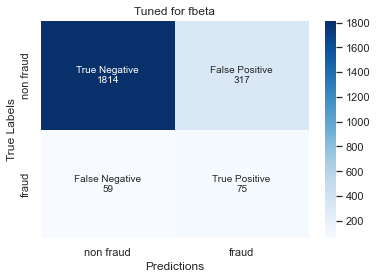

In [16]:
#Confusion Matrix
get_confusion_matrix(y_valid,y_pred, "Tuned for fbeta")

In [17]:
# make predictions for test data
y_pred2 = test.predict(X_test)
predictions = [round(value) for value in y_pred2]

# evaluate predictions
precision = precision_score(y_test, y_pred2)
accuracy = accuracy_score(y_test, y_pred2)
recall = recall_score(y_test, y_pred2)
f1 = f1_score(y_test, y_pred2)
fbeta = fbeta_score(y_test, y_pred2, beta=2)
roc_auc = roc_auc_score(y_test, y_pred2)
pr_auc = average_precision_score(y_test, y_pred2)

print("Precision: %.3f%%" % (precision * 100.0))
print("Accuracy: %.3f%%" % (accuracy * 100.0))
print("Recall: %.3f%%" % (recall * 100.0))
print("F1: %.3f" % f1)
print("Fbeta: %.3f" % fbeta)
print("ROC AUC: %.3f" % roc_auc)
print("PR AUC: %.3f" % pr_auc )

Precision: 18.033%
Accuracy: 85.475%
Recall: 41.045%
F1: 0.251
Fbeta: 0.327
ROC AUC: 0.647
PR AUC: 0.109


### SHAP

In [18]:
#creating a feature list
features  = df_train.drop('FraudFound_P', axis=1).columns.tolist()
feature_dict = {}
for num in range(53):
    feature_key = "f" + str(num)
    feature_dict[feature_key] = features[num]
print(feature_dict)

{'f0': 'MonthClaimed', 'f1': 'VehiclePrice', 'f2': 'Deductible', 'f3': 'DriverRating', 'f4': 'Days_Policy_Accident', 'f5': 'Days_Policy_Claim', 'f6': 'PastNumberOfClaims', 'f7': 'AgeOfVehicle', 'f8': 'AgeOfPolicyHolder', 'f9': 'NumberOfSuppliments', 'f10': 'AddressChange_Claim', 'f11': 'NumberOfCars', 'f12': 'Year', 'f13': 'AccidentArea_IsUrban', 'f14': 'Sex_IsMale', 'f15': 'Fault_IsPolicyholder', 'f16': 'PoliceReportFiled_IsYes', 'f17': 'WitnessPresent_IsYes', 'f18': 'AgentType_IsExternal', 'f19': 'isWithinAgeRange_IsTrue', 'f20': 'Make_Accura', 'f21': 'Make_BMW', 'f22': 'Make_Chevrolet', 'f23': 'Make_Dodge', 'f24': 'Make_Ford', 'f25': 'Make_Honda', 'f26': 'Make_Jaguar', 'f27': 'Make_Lexus', 'f28': 'Make_Mazda', 'f29': 'Make_Mecedes', 'f30': 'Make_Mercury', 'f31': 'Make_Nisson', 'f32': 'Make_Pontiac', 'f33': 'Make_Porche', 'f34': 'Make_Saab', 'f35': 'Make_Saturn', 'f36': 'Make_Toyota', 'f37': 'Make_VW', 'f38': 'MaritalStatus_Divorced', 'f39': 'MaritalStatus_Married', 'f40': 'MaritalSt

In [19]:
X_display = df_train.drop('FraudFound_P', axis=1)

In [20]:
import shap
shap.initjs()

In [21]:
explainer = shap.TreeExplainer(test)
shap_values = explainer.shap_values(X_train_resampled)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


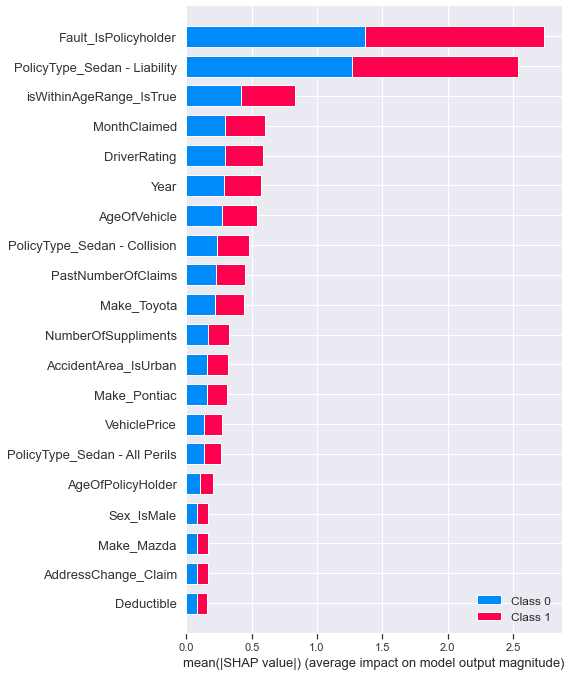

In [22]:
#featuere importance
shap.summary_plot(shap_values, X_display, plot_type="bar")